In [1]:
from phi.agent import Agent
#from phi.model.openai import OpenAIChat
#from phi.tools.duckduckgo import DuckDuckGo
import os
import math
from phi.model.ollama import Ollama
from pydantic import BaseModel, Field
import pandas as pd
from phi.knowledge.text import TextKnowledgeBase
from phi.vectordb.pgvector import PgVector
from owlready2 import *
from io import StringIO
from icecream import ic
import json
from phi.agent import Agent, RunResponse
from phi.model.groq import Groq
import numpy as  np 

In [ ]:
groq_key = "...."


def clear_kb(connection = "ai:ai@localhost:5532/ai",table_name = "University Ontology" ):
    from sqlalchemy import create_engine, text

    engine = create_engine(f"postgresql+psycopg://{connection}")
    with engine.connect() as conn:
        result = conn.execute(text(f'DELETE FROM "{table_name}";'))
        print(result)
# clear_kb()
class Response(BaseModel):
    user_question: str = Field(description="User's question")
    thoughts: str = Field(description="Reasoning to answer the users'question.")    
    discrete_answer: str = Field(description="Discrete answer (Yes, No) to the user's question.")

knowledge_base = TextKnowledgeBase(
    path="./data/univ-bench.txt",
    # Table name: ai.text_documents
    vector_db=PgVector(
        table_name="University Ontology",
        db_url="postgresql+psycopg://ai:ai@localhost:5532/ai",
    ),
)


def clean_json(string):
    import json
    from json_repair import repair_json
    clean = string.content.replace('```json\\n', '').replace('\\n```', '')
    clean = clean.encode().decode('unicode_escape')

    # Step 3: Use json-repair to ensure it is valid
    repaired = repair_json(clean)

    # Step 4: Load it
    data = json.loads(repaired)

    # Use it
    # print(data['discrete_answer'])  # Output: yes
    return data



eng_prompt_premise = """
You are an expert knowledge engineer with deep understanding of OWL (Web Ontology Language). 
Given the LUBM (Lehigh University Benchmark) as knowledge base, your task is to reply to the user query making inference.  
Your task is to answer query by leveraging your comprehensive knowledge of OWL axioms, relying exclusively on the LUBM ontology stored in your knowledge base and the individuals definde in the premise passed by the user. 
The user will pass you a premise correctly describing individuals on the LUBM ontology, their relationships or properties. The user will also pass you a query to answer with 'yes' or 'no' based on the premise.
You can use the premise correctly defining individuals on the ontology for replying the user query with 'yes' or 'no' and provide a reasonable explanation based on your ontology understanding.
Please provide detailed, precise responses that demonstrate your expertise in knowledge representation and ontological reasoning within the specific context of the LUBM (Lehigh University Benchmark) ontology.  
"""
eng_instructions_premise = [
    "Carefully read and parse the premise provided by the user, which defines individuals and their relationships within the LUBM ontology context.",
    "Identify the key entities, properties, and relationships mentioned in the premise (e.g., Person, Student, TeachingAssistant, Course, taking, teachingAssistantOf).",
    "Apply your knowledge of LUBM ontology axioms and class hierarchies to understand the semantic relationships between the entities mentioned in the premise.",
    "Base your reasoning exclusively on the LUBM ontology structure and the premise provided. Do not use external knowledge or assumptions beyond what is defined in LUBM.",
    "Answer the query provided by the user with 'yes' or 'no', base your response rationale only on your ability di apply OWL axioms on the LUBM ontology.",
    'Structure your response in valid JSON format with the following fields:\n   - "user_question": the exact query asked\n   - "thoughts": detailed reasoning process showing how you applied LUBM ontology knowledge\n   - "discrete_answer": either "yes" or "no".',
    "Ensure your reasoning (thoughts) logically supports your discrete_answer. If the answer is 'no', explain why the query cannot be positively concluded from the given information.",
    "Your response must be valid JSON only, without any additional text, explanations, or the word 'JSON'."
]

# def get_response_w_premise(agent,item,prompt_question,i=0):
def get_response(agent,item,prompt_question,premise=True, i=0):
    print("obtaingin response with model: ",agent.model.id )
    print(f"evaluating this query ... \n {prompt_question}")
    try:
        final_answer = agent.run(prompt_question)
        try:
            json.loads(final_answer.content)

        except Exception as e:
            print("cleaning string to json because of error: ", e)
            final_answer = clean_json(final_answer)
            if type(final_answer) == list:
                final_answer = final_answer[-1]
            print("res after cleaning string ", final_answer)
        if type(final_answer) == dict:
            print("obtained dict after cleaning: ", final_answer)
            if premise:
                return (item["id"], item['premise'],item["query"], item["correct_answer"], final_answer["discrete_answer"], final_answer["thoughts"])
            return (item["id"],item["query"], item["correct_answer"], final_answer["discrete_answer"], final_answer["thoughts"])
            

        print("USER QUESTION:", json.loads(final_answer.content)["user_question"])
        print("THOUGHTS:", json.loads(final_answer.content)["thoughts"])
        print("ANSWER:", json.loads(final_answer.content)["discrete_answer"])
        if premise: 
            return (item["id"], item['premise'],item["query"], item["correct_answer"], json.loads(final_answer.content)["discrete_answer"], json.loads(final_answer.content)["thoughts"])
        return (item["id"],item["query"], item["correct_answer"], json.loads(final_answer.content)["discrete_answer"], json.loads(final_answer.content)["thoughts"])

    except Exception as e: 
        print("error in processing query: ",prompt_question, e)
        if i<5: 
            print("trying again: ", i)
            return get_response(agent,item,prompt_question,premise= premise, i=i+1)
        if premise:
            return(item["id"], item['premise'], item["query"], item["correct_answer"], "error", "error in evaluating query")
        return (item["id"],item["query"], item["correct_answer"], "error", "error in evaluating queery")


def run_experiment(system_prompt,instructions, model_id, ground_data,generate_resp_function,consider_premise=True,output_csv_name=''):
    clear_kb()
    knowledge_base = TextKnowledgeBase(
        path="./data/univ-bench.txt",
        # Table name: ai.text_documents
        vector_db=PgVector(
            table_name="University Ontology",
            db_url="postgresql+psycopg://ai:ai@localhost:5532/ai",
        ),
    )
    
    agent = Agent(
        name = f"agent_{model_id}",
        model = Groq(api_key=groq_key, id=model_id),
        # model=Ollama(id="llama3.1:8b"),
        # model = OpenAIChat(id="gpt-4o"),
        #tools = [process_owl],
        description=system_prompt,
        instructions=instructions,
        markdown = True,  
        reasoning = False,
        structured_outputs = True,  
        debug_mode=False,
        knowledge_base=knowledge_base,
        # response_model=Response,
        search_knowledge=True,
        verbose = False,
    )
    agent.knowledge.load(recreate=True)
    
    results_list = list()
    for item in ground_data:
        if consider_premise:

            premise = item['premise']
            query = item["query"]
            prompt_question = f"""Consider this premise:{premise} \n  The user query is the following: "{query}."""
            print("evaluating: ", prompt_question)
                
        else:
            query = item["full_query"]
            prompt_question = f""" The user query is the following: "{query}"."""
            # print("evaluating: ", prompt_question)
        results_list.append(generate_resp_function(agent,item,prompt_question,consider_premise))
        print("processed instance ", item['id'])
    if consider_premise:
        _columns = ["id","premise", "query", "correct_answer", "discrete_answer", "thoughts"]
    else:
        _columns = ["id","query", "correct_answer", "discrete_answer", "thoughts"]
    result_premise_df = pd.DataFrame(results_list, columns=_columns)
    result_premise_df["correct_answer"]=result_premise_df["correct_answer"].apply(str.lower)
    result_premise_df["discrete_answer"]=result_premise_df["discrete_answer"].apply(str.lower)
    if output_csv_name:
        result_premise_df.to_csv(f"results/{output_csv_name}.csv")
    return result_premise_df

# def get_response(agent,item,prompt_question,i=0):
#     try:
#         final_answer = agent.run(prompt_question)
#         # return final_answer
#         try:
#             json.loads(final_answer.content)
#         except Exception as e :
#             print("cleaning string to json due to: ", e)
#             final_answer = clean_json(final_answer)

#         print("USER QUESTION:", json.loads(final_answer.content)["user_question"])
#         print("THOUGHTS:", json.loads(final_answer.content)["thoughts"])
#         print("ANSWER:", json.loads(final_answer.content)["discrete_answer"])
#         return (item["id"], item["query"], item["correct_answer"], json.loads(final_answer.content)["discrete_answer"], json.loads(final_answer.content)["thoughts"])
    
#     except Exception as e: 
#         print("error in processing query: ",prompt_question, e)
#         if i<5: 
#             print("trying again: ", i)
#             return get_response(agent,prompt_question,i=i+1)
#         return(item["id"], item["query"], item["correct_answer"], "error", "error in evaluating query")




In [31]:
X = pd.read_csv("results/results_newset/qwen-qwq-32b_premise.csv")
[i for i in X.index + 1 ]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53]

In [5]:
## funz modificata per considerare tipi di inferenza 
def create_report(results_df,full_queries_df): 
    from sklearn.metrics import accuracy_score
    model_accuracy = accuracy_score(results_df['correct_answer'], results_df['discrete_answer'])
    print("model accuracy: ", model_accuracy, "sample size: ", len(results_df))
    print("valid answers: ", len(results_df[results_df['discrete_answer'].isin(["yes","no"])]))
    no_error_sub = results_df[results_df['discrete_answer'].isin(["yes","no"])]
    model_accuracy_no_err = accuracy_score(no_error_sub['correct_answer'], no_error_sub['discrete_answer'])
    print("model accuracy not considering errors: ", model_accuracy_no_err, "sample size: ", len(no_error_sub))

    errors = no_error_sub[no_error_sub["discrete_answer"]!= no_error_sub['correct_answer']]
    # errors_id = errors['id']
    errors_id = [i for i in errors.index + 1]
    # full_queries_df = pd.DataFrame(json_data)
    levels_count = full_queries_df[full_queries_df['id'].isin(errors_id)]['level']
    [print("level: ",i,"error: ", x) for i,x in zip(np.unique_counts(levels_count)[0],np.unique_counts(levels_count)[1] )]


    type_count = full_queries_df[full_queries_df['id'].isin(errors_id)]['type']
    if "type" in full_queries_df.columns:
        [print("inference type: ",i,"correct instances: ", x) for i,x in zip(np.unique_counts(type_count)[0],np.unique_counts(type_count)[1] )]

    correct = no_error_sub[no_error_sub["discrete_answer"]== no_error_sub['correct_answer']]
    correct_id = correct['id']
    # print('correct id', correct_id)
    levels_count_correct = full_queries_df[full_queries_df['id'].isin(correct_id)]['level']
    [print("level: ",i,"correct instances: ", x) for i,x in zip(np.unique_counts(levels_count_correct)[0],np.unique_counts(levels_count_correct)[1] )]
    type_count_correct = full_queries_df[full_queries_df['id'].isin(correct_id)]['type']
    if "type" in full_queries_df.columns:
        [print("inference type: ",i,"correct instances: ", x) for i,x in zip(np.unique_counts(type_count_correct)[0],np.unique_counts(type_count_correct)[1] )]



    ## return id corretti e id errors
    return correct_id,errors_id


In [2]:
## dataset 

json_file_path = "./queries_newset.json"
with open(json_file_path, "r", encoding="utf-8") as json_file:
    json_data_premise = json.load(json_file)

newset_df = pd.DataFrame(json_data_premise)
newset_df['id'] = np.arange(1,len(newset_df)+1)
newset_df['full_query'] = newset_df['premise'] + " " + newset_df['query']
newset_df

,premise,query,correct_answer,level,id,type,full_query
0,X is a student.,Is X a person?,Yes,1,1,instance-class classification,X is a student. Is X a person?
1,X is a faculty member.,Is X a person?,Yes,2,2,instance-class classification,X is a faculty member. Is X a person?
2,X is a person.,Is X an employee?,No,1,3,instance-class classification,X is a person. Is X an employee?
3,X is a work.,Is X a graduate level course?,No,2,4,instance-class classification,X is a work. Is X a graduate level course?
4,X works for Y.,Is X a member of Y?,Yes,1,5,instance-property classification,X works for Y. Is X a member of Y?
5,X is the head of Y.,Is X a member of Y?,Yes,2,6,instance-property classification,X is the head of Y. Is X a member of Y?
6,X is a member of Y.,Does X work for Y?,No,1,7,instance-property classification,X is a member of Y. Does X work for Y?
7,X is a member of Y.,Is X the head of Y?,No,2,8,instance-property classification,X is a member of Y. Is X the head of Y?
8,X is person. X works for Y. Y is an organization.,Is X an employee?,Yes,1,9,instance-class equivalence,X is person. X works for Y. Y is an organizati...
9,X is person.,Is X a chair?,No,1,10,instance-class equivalence,X is person. Is X a chair?


In [24]:
[print(i, ":",v) for i,v in zip(np.unique(newset_df['type'],return_counts=True)[0],np.unique(newset_df['type'],return_counts=True)[1])]

class subsumption : 4
domain-range : 10
domain-range + instance-class classification : 4
instance-class classification : 4
instance-class equivalence : 7
instance-class equivalence + instance-class classification : 2
instance-property classification : 4
inverse property : 4
property subsumption : 4
transitive property : 6
transitive property + instance-class classification + domain-range : 4


[None, None, None, None, None, None, None, None, None, None, None]

## exp premimse + query

In [6]:
eng_prompt_premise = """
You are an expert knowledge engineer specializing in OWL (Web Ontology Language) and semantic reasoning. Your task is to answer user queries using the LUBM (Lehigh University Benchmark) ontology.

Rely only on the LUBM ontology provided in the knowledge base and do not consider additional version of such ontology.

You will be provided with:
1. A *premise*, describing individuals and their relationships according to the LUBM ontology.
2. A *query*, which you must answer using OWL axioms and reasoning, strictly within the LUBM ontology context.

Use only the relationships and class/property hierarchies defined in LUBM and the information explicitly provided in the premise. Do not use external facts or assumptions. Your task is to reason over the OWL semantics (e.g., `subClassOf`, `subPropertyOf`, `domain`, `range`, transitivity) and answer the query with either `"yes"` or `"no"`, followed by a clear reasoning trail.

Return your response as **valid JSON only**, structured as:
- `"user_question"`: the original query string,
- `"thoughts"`: detailed reasoning using OWL/LUBM semantics,
- `"discrete_answer"`: either `"yes"` or `"no"`.

Your explanation must demonstrate deep understanding of OWL and justify the conclusion clearly.
"""


eng_instructions_premise = """
1. Carefully read and parse the *premise* provided by the user, which contains individual-level assertions using classes and properties from the LUBM ontology.
2. Identify relevant entities (e.g., `Professor`, `Student`, `Department`) and properties (e.g., `headOf`, `worksFor`, `memberOf`) present in the premise.
3. Apply OWL reasoning principles (e.g., `subPropertyOf`, `subClassOf`, `transitivity`, `inference over domains/ranges`) using the LUBM ontology.
4. Avoid using external world knowledge or facts not derivable from the LUBM ontology or the given premise.
5. Determine whether the query can be answered *exclusively* by logically inferring from the LUBM ontology and the premise.
6. Provide your answer in JSON format with the following fields:
   - `"user_question"`: the original user query string,
   - `"thoughts"`: your complete reasoning process (step-by-step logic applied),
   - `"discrete_answer"`: one of `"yes"` or `"no"`.
7. Make sure the reasoning in `"thoughts"` clearly and logically supports the `"discrete_answer"`.
8. Do not include anything outside the JSON object (no explanations, introductions, or formatting labels like “Answer:” or “JSON:”).

"""

In [ ]:
llama3_3_premise_results = run_experiment(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    model_id="llama-3.3-70b-versatile",
    ground_data=json_data_premise,
    generate_resp_function=get_response,
    consider_premise=True,
    output_csv_name="results_newset/new_instructions_llama_3_3_versatile_premise"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:  Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  llama-3.3-70b-versatile
cleaning string to json because of error:  Expecting value: line 1 column 1 (char 0)
res after cleaning string  {'user_question': 'Is X a person?', 'thoughts': 'In the LUBM ontology, a Student is a subclass of Person. This means that every Student is also a Person. Given the premise that X is a Student, we can infer that X is also a Person due to the subclass relationship between Student and Person in the LUBM ontology.', 'discrete_answer': 'yes'}
obtained dict after cleaning:  {'user_question': 'Is X a person?', 'thoughts': 'In the LUBM ontology, a Student is a subclass of Person. This means that every Student is also a Person. Given the premise that X is a Student, we can infer that X is also a Person due to the subclass relationship between Student and Person in the LUBM ontology.', 'discrete_answer': 'yes'}
processed instanc

In [18]:
llama3_3_premise_results['id'] = np.arange(1,len(llama3_3_premise_results) + 1)
create_report(llama3_3_premise_results, newset_df)

model accuracy:  0.8301886792452831 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8301886792452831 sample size:  53
level:  1 error:  5
level:  2 error:  3
level:  3 error:  1
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  1
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-property classification correct instances:  2
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  24
level:  2 correct instances:  17
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  9
inference type:  domain-range + instance-class classification correct instances:  4
inference type:  instance-cla

(0      1
 1      2
 2      3
 3      4
 6      7
 7      8
 8      9
 9     10
 10    11
 11    12
 14    15
 15    16
 16    17
 18    19
 19    20
 21    22
 22    23
 23    24
 24    25
 25    26
 26    27
 27    28
 28    29
 29    30
 31    32
 32    33
 33    34
 34    35
 35    36
 36    37
 38    39
 39    40
 40    41
 41    42
 42    43
 43    44
 44    45
 45    46
 47    48
 48    49
 49    50
 50    51
 51    52
 52    53
 Name: id, dtype: int64,
 4      5
 5      6
 12    13
 13    14
 17    18
 20    21
 30    31
 37    38
 46    47
 Name: id, dtype: int64)

### llama3 70b

In [7]:
llama3_70b = run_experiment(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    model_id="llama3-70b-8192",
    ground_data=json_data_premise,
    generate_resp_function=get_response,
    consider_premise=True,
    output_csv_name="results_newset/llama3_70b_premise"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:  Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  llama3-70b-8192
evaluating this query ... 
 Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
cleaning string to json because of error:  Expecting ',' delimiter: line 3 column 342 (char 378)
res after cleaning string  {'user_question': 'Is X a person?', 'thoughts': 'From the LUBM ontology, we know that `Student` is a subclass of `GraduateStudent`, which in turn is a subclass of `Person`. Given the premise that `X is a student`, we can infer that `X` is a `Student`. Since `Student` is a subclass of `Person`, we can conclude that `X` is a `Person`. Therefore, we can answer the query with `"yes"`', 'discrete_answer': 'yes'}
obtained dict after cleaning:  {'user_question': 'Is X a person?', 'thoughts': 'From the LUBM ontology, we know that `Student` is a subclass of `GraduateStudent`, which in turn is a subclass of 

In [8]:
llama3_70b_premise_correct_ids, llama3_70b_premise_error_ids = create_report(llama3_70b, newset_df)

model accuracy:  0.7924528301886793 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.7924528301886793 sample size:  53
level:  1 error:  8
level:  2 error:  2
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  2
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  1
inference type:  instance-property classification correct instances:  1
inference type:  inverse property correct instances:  2
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  1
level:  1 correct instances:  22
level:  2 correct instances:  15
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  4
inference type:  domain-range correct instances:  5
inference type:  domain-range + instance-class classification correct instances:  3
inference type:

### deepseek distil

In [115]:
deepseek_llama_premise_results = run_experiment(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    model_id="deepseek-r1-distill-llama-70b",
    ground_data=json_data_premise,
    generate_resp_function=get_response,
    consider_premise=True,
    output_csv_name="results_newset/deepseek_llama_premise"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:  Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  deepseek-r1-distill-llama-70b
cleaning string to json because of error:  Expecting value: line 1 column 1 (char 0)
res after cleaning string  {'user_question': 'Is X a person?', 'thoughts': "In the LUBM ontology, 'Student' is defined as a subclass of 'Person'. This means that any individual who is a 'Student' is also a 'Person'. The premise states that X is a 'Student', so by the subclass relationship, X must be a 'Person'.", 'discrete_answer': 'yes'}
obtained dict after cleaning:  {'user_question': 'Is X a person?', 'thoughts': "In the LUBM ontology, 'Student' is defined as a subclass of 'Person'. This means that any individual who is a 'Student' is also a 'Person'. The premise states that X is a 'Student', so by the subclass relationship, X must be a 'Person'.", 'discrete_answer': 'yes'}
processed instance  1
evaluating:  Consider this premise:X is a

In [116]:
deepseek_premise_correct_ids, deepseek_premise_error_ids = create_report(deepseek_llama_premise_results, newset_df)

model accuracy:  0.8490566037735849 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8490566037735849 sample size:  53
level:  1 error:  3
level:  2 error:  3
level:  3 error:  1
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  1
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-property classification correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  26
level:  2 correct instances:  15
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  6
inference type:  domain-range + instance-class classification correct instances:  4
inference type:  instance-class classification correct instances:  4
inference type:  ins

### qwen-qwq-32b

In [117]:
qwen_premise_results = run_experiment(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    model_id="qwen-qwq-32b",
    ground_data=json_data_premise,
    generate_resp_function=get_response,
    consider_premise=True,
    output_csv_name="results_newset/qwen-qwq-32b_premise"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:  Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  qwen-qwq-32b
USER QUESTION: Is X a person?
THOUGHTS: According to the LUBM ontology, the class Student is a direct subclass of Person (see lubm:Student rdfs:subClassOf lubm:Person). Since the premise states that X is a Student, it logically follows by OWL semantics that X is also an instance of Person. This conclusion relies solely on the subClassOf hierarchy without requiring additional premises.
ANSWER: yes
processed instance  1
evaluating:  Consider this premise:X is a faculty member. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  qwen-qwq-32b
USER QUESTION: Is X a person?
THOUGHTS: In LUBM, the hierarchy is Person → Employee → Faculty. Since X is a faculty member (member of Faculty class), and Faculty is a subclass of Employee (which is itself a subclass of Person), X must be an instance of Person via subclass 

In [118]:
qwen_premise_correct_ids, qwen_premise_error_ids = create_report(qwen_premise_results, newset_df)

model accuracy:  0.8113207547169812 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8113207547169812 sample size:  53
level:  1 error:  5
level:  2 error:  3
level:  3 error:  1
inference type:  class subsumption correct instances:  2
inference type:  domain-range correct instances:  1
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-class equivalence + instance-class classification correct instances:  1
inference type:  instance-property classification correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  24
level:  2 correct instances:  15
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  2
inference type:  domain-range correct instances:  6
inference type:  domain-range + instance-class classification correct insta

### llama 4

In [122]:
llama4_premise_results = run_experiment(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    model_id="meta-llama/llama-4-maverick-17b-128e-instruct",
    ground_data=json_data_premise,
    generate_resp_function=get_response,
    consider_premise=True,
    output_csv_name="results_newset/llama4_premise"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:  Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
obtaingin response with model:  meta-llama/llama-4-maverick-17b-128e-instruct
evaluating this query ... 
 Consider this premise:X is a student. 
  The user query is the following: "Is X a person?.
cleaning string to json because of error:  Expecting value: line 1 column 1 (char 0)
res after cleaning string  {'user_question': 'Is X a person?', 'thoughts': "In the LUBM ontology, 'Student' is a subclass of 'Person'. Since X is a student, and 'Student' is a subclass of 'Person', we can infer that X is a 'Person'.", 'discrete_answer': 'yes'}
obtained dict after cleaning:  {'user_question': 'Is X a person?', 'thoughts': "In the LUBM ontology, 'Student' is a subclass of 'Person'. Since X is a student, and 'Student' is a subclass of 'Person', we can infer that X is a 'Person'.", 'discrete_answer': 'yes'}
processed instance  1
evaluating:  Consider this premise:X is a faculty member. 
  The u

In [123]:
llama4_premise_correct_ids, llama4_premise_error_ids = create_report(llama4_premise_results, newset_df)

model accuracy:  0.8679245283018868 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8679245283018868 sample size:  53
level:  1 error:  3
level:  2 error:  2
level:  3 error:  1
inference type:  domain-range correct instances:  2
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  26
level:  2 correct instances:  15
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  4
inference type:  domain-range correct instances:  5
inference type:  domain-range + instance-class classification correct instances:  3
inference type:  instance-class classification correct instances:  4
inference type:  instance-class equivalence correct instances:  6

### llama3.1-8b

In [126]:


def get_response_ollama(agent,item,prompt_question,i=0):
    print("evaluating: ", prompt_question)

    try:
        final_answer = agent.run(prompt_question)
        answer_json = {
            "user_question" : final_answer.content.user_question,
            "discrete_answer" : final_answer.content.discrete_answer,
            "thoughts" : final_answer.content.thoughts,

        }
        # answer_json = json.loads(_answer) 
        # try:
        #     json.loads(final_answer.content)
        # except:
        #     print("cleaning string to json")
        #     print("fin answer : ", final_answer.content.thoughts)
        #     print(type(final_answer.content))
        #     final_answer = clean_json(final_answer.content)

        # print("USER QUESTION:", json.loads(final_answer.content)["user_question"])
        # print("THOUGHTS:", json.loads(final_answer.content)["thoughts"])
        # print("ANSWER:", json.loads(final_answer.content)["discrete_answer"])
        return (item["id"], item["query"], item["correct_answer"], answer_json["discrete_answer"], answer_json["thoughts"])
    
    except Exception as e: 
        print("error in processing query: ",prompt_question, e)
        if i<5: 
            print("trying again: ", i)
            return get_response(agent,prompt_question,i=i+1)
        return(item["id"], item['premise'], item["query"], item["correct_answer"], "error", "error in evaluating query")

def run_experiment_ollama(system_prompt,instructions, ground_data,generate_resp_function, output_csv_name,model_id = "llama3.1:8b"):
    clear_kb()
    knowledge_base = TextKnowledgeBase(
        path="./data/univ-bench.txt",
        # Table name: ai.text_documents
        vector_db=PgVector(
            table_name="University Ontology",
            db_url="postgresql+psycopg://ai:ai@localhost:5532/ai",
        ),
    )
    
    agent = Agent(
        name = "agent",
        # model = Groq(api_key=groq_key, id=model_id),
        model=Ollama(id=model_id),
        # model = OpenAIChat(id="gpt-4o"),
        #tools = [process_owl],
        description=system_prompt,
        instructions=instructions,
        markdown = True,  
        reasoning = False,
        structured_outputs = True,  
        debug_mode=False,
        knowledge_base=knowledge_base,
        response_model=Response,
        search_knowledge=True,
        verbose = False,
    )
    agent.knowledge.load(recreate=True)
    
    results_list = list()
    for item in ground_data:
        premise = item['premise']
        query = item["query"]
        prompt_question = f""" Consdier this premise: {premise}. \n The user query is the following: "{query}"."""
        results_list.append(generate_resp_function(agent,item,prompt_question))
        print("processed instance ", item['id'])    
    # return results_list
    result_df = pd.DataFrame(results_list, columns=["id", "query", "correct_answer", "discrete_answer", "thoughts"])
    result_df["correct_answer"]=result_df["correct_answer"].apply(str.lower)
    result_df["discrete_answer"]=result_df["discrete_answer"].apply(str.lower)
    result_df.to_csv(f"results/{output_csv_name}.csv")
    return result_df

llama3_1_8b_premise_results = run_experiment_ollama(
    system_prompt=eng_prompt_premise,
    instructions=eng_instructions_premise,
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response_ollama,
    output_csv_name="results_newset/llama3_1_8b_premise"
)



INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   Consdier this premise: X is a student.. 
 The user query is the following: "Is X a person?".
processed instance  1
evaluating:   Consdier this premise: X is a faculty member.. 
 The user query is the following: "Is X a person?".
processed instance  2
evaluating:   Consdier this premise: X is a person.. 
 The user query is the following: "Is X an employee?".
processed instance  3
evaluating:   Consdier this premise: X is a work.. 
 The user query is the following: "Is X a graduate level course?".
processed instance  4
evaluating:   Consdier this premise: X works for Y.. 
 The user query is the following: "Is X a member of Y?".
processed instance  5
evaluating:   Consdier this premise: X is the head of Y.. 
 The user query is the following: "Is X a member of Y?".
processed instance  6
evaluating:   Consdier this premise: X is a member of Y.. 
 The user query is the following: "Does X work for Y?".
processed instance  7
evaluating:   Consdier this premise: X is a member of Y

In [127]:
llama_31_8b_premise_correct_ids, llama_31_8b_premise_error_ids = create_report(llama3_1_8b_premise_results, newset_df)

model accuracy:  0.7547169811320755 sample size:  53
valid answers:  52
model accuracy not considering errors:  0.7692307692307693 sample size:  52
level:  1 error:  5
level:  2 error:  7
inference type:  class subsumption correct instances:  1
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class classification correct instances:  2
inference type:  instance-class equivalence correct instances:  1
inference type:  instance-class equivalence + instance-class classification correct instances:  1
inference type:  instance-property classification correct instances:  1
inference type:  inverse property correct instances:  2
inference type:  transitive property correct instances:  3
level:  1 correct instances:  24
level:  2 correct instances:  12
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  10
inference type:  domain-range + instance-cl

## exp considerando full query no premise

In [16]:
eng_instructions_premise

['Carefully read and parse the premise provided by the user, which defines individuals and their relationships within the LUBM ontology context.',
 'Identify the key entities, properties, and relationships mentioned in the premise (e.g., Person, Student, TeachingAssistant, Course, taking, teachingAssistantOf).',
 'Apply your knowledge of LUBM ontology axioms and class hierarchies to understand the semantic relationships between the entities mentioned in the premise.',
 'Base your reasoning exclusively on the LUBM ontology structure and the premise provided. Do not use external knowledge or assumptions beyond what is defined in LUBM.',
 "Answer the query provided by the user with 'yes' or 'no', base your response rationale only on your ability di apply OWL axioms on the LUBM ontology.",
 'Structure your response in valid JSON format with the following fields:\n   - "user_question": the exact query asked\n   - "thoughts": detailed reasoning process showing how you applied LUBM ontology k

In [128]:
newset_df
eng_prompt = """
You are an expert knowledge engineer with deep understanding of OWL (Web Ontology Language). 
Your task is to answer questions by leveraging your comprehensive knowledge of OWL axioms, relying exclusively on the LUBM ontology stored in your knowledge base. 
Please provide detailed, precise responses that demonstrate your expertise in knowledge representation and ontological reasoning within the specific context of the LUBM (Lehigh University Benchmark) ontology.  
"""
eng_instructions = [
    "To answer the user's question, you will use the search tool to access the knowledge base containing the LUBM ontology", 
    "You will not use information not present in LUBM to answer the user's question",
    "Your response must be structured in JSON format that includes the same question (user_question), a rationale (thoughts), a discrete answer (discrete_answer): either yes or no, and finally a self-assessment (self-explanation) of the exclusive use of LUBM to answer the question",
    "Ensure that the JSON response is syntactically valid. Make sure that the reasoning (thoughts) is consistent with the answer (discrete_answer)."
    'Your answer MUST be in this form and not containing anything else. Do not include the word JSON in your answer: {"user_question" : "", "thoughts" : "", "discrete_answer" : ""}'
]

### llama3-370b-versatile

In [21]:
llama3_3_newset_results = run_experiment(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    model_id="llama-3.3-70b-versatile",
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response,
    consider_premise=False,
    output_csv_name="results_newset/newset_llama_3_3_versatile"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
obtaingin response with model:  llama-3.3-70b-versatile
USER QUESTION: X is a student. Is X a person?
THOUGHTS: The LUBM ontology defines a class 'Student' that is equivalent to the intersection of 'Person' and the restriction 'takesCourse' some 'Course'. This means that every 'Student' is also a 'Person'. Therefore, if X is a 'Student', then X must also be a 'Person'.
ANSWER: yes
error in processing query:   The user query is the following: "X is a student. Is X a person?". string indices must be integers, not 'str'
trying again:  0
obtaingin response with model:  llama-3.3-70b-versatile
cleaning string to json because of error:  Expecting value: line 1 column 1 (char 0)
res after cleaning string  {'user_question': 'The user query is the following: "X is a student. Is X a person?"', 'thoughts': 'In the LUBM ontology, a student is a subclass of a person, as indicated by the relationship `Student subClassOf

In [23]:
llama3_3_70b_correct_ids, llama3_3_70b_error_ids = create_report(llama3_3_newset_results,newset_df)

model accuracy:  0.8490566037735849 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8490566037735849 sample size:  53
level:  1 error:  3
level:  2 error:  5
inference type:  class subsumption correct instances:  1
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-property classification correct instances:  1
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  2
level:  1 correct instances:  26
level:  2 correct instances:  15
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  10
inference type:  domain-range + instance-class classification correct instances:  3
inference type:  instance-class classification correct instances:  4
inference type:  instance-class equivalence correct i

### llama3-70b

In [28]:
llama3_newset_results = run_experiment(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    model_id="llama3-70b-8192",
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response,
    consider_premise=False,
    output_csv_name="results_newset/llama_3_70b"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
obtaingin response with model:  llama3-70b-8192
USER QUESTION: The user query is the following: "X is a student. Is X a person?" 
THOUGHTS: Since X is a student, I will explore the hierarchy of student in the LUBM ontology. The LUBM ontology defines a student as a subtype of UndergraduateStudent or GraduateStudent. Both of these classes are subclasses of Student. Therefore, I can infer that X, being a student, is also a person.
ANSWER: yes
processed instance  1
evaluating:   The user query is the following: "X is a faculty member. Is X a person?".
obtaingin response with model:  llama3-70b-8192
USER QUESTION: X is a faculty member. Is X a person?
THOUGHTS: In the LUBM ontology, we have the axiom `ub:FacultyMember rdfs:subClassOf ub:Person`, which indicates that every FacultyMember is a Person. Therefore, if X is a faculty member, it is a person.
ANSWER: yes
processed instance  2
evaluating:   The user quer

In [30]:
llama3_newset_results

,id,query,correct_answer,discrete_answer,thoughts
0,1,Is X a person?,yes,yes,"Since X is a student, I will explore the hiera..."
1,2,Is X a person?,yes,yes,"In the LUBM ontology, we have the axiom `ub:Fa..."
2,3,Is X an employee?,no,no,"To determine if X is an employee, we can check..."
3,4,Is X a graduate level course?,no,no,"To answer this question, I will check if there..."
4,5,Is X a member of Y?,yes,yes,The property 'worksFor' is a functional proper...
5,6,Is X a member of Y?,yes,yes,We can answer this query by leveraging the LUB...
6,7,Does X work for Y?,no,yes,"To answer this question, we need to check if t..."
7,8,Is X the head of Y?,no,no,The LUBM ontology does not provide direct info...
8,9,Is X an employee?,yes,yes,"In the LUBM ontology, the 'worksFor' property ..."
9,10,Is X a chair?,no,no,"According to the LUBM ontology, a Person is a ..."


In [29]:
llama3_70b_correct_ids, llama3_70b_error_ids = create_report(llama3_newset_results,newset_df)


model accuracy:  0.7924528301886793 sample size:  53
valid answers:  52
model accuracy not considering errors:  0.8076923076923077 sample size:  52
level:  1 error:  7
level:  2 error:  3
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  1
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-property classification correct instances:  1
inference type:  inverse property correct instances:  1
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  2
level:  1 correct instances:  21
level:  2 correct instances:  17
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  9
inference type:  domain-range + instance-class classification correct instances:  3
inference type:

### llama 4 maverick 

In [62]:
llama4_results = run_experiment(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    model_id="meta-llama/llama-4-maverick-17b-128e-instruct",
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response,
    consider_premise=False,
    output_csv_name="results_newset/llama4"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
obtaingin response with model:  meta-llama/llama-4-maverick-17b-128e-instruct
USER QUESTION: X is a student. Is X a person?
THOUGHTS: According to the LUBM ontology, the class 'Student' is defined as equivalent to the intersection of 'Person' and the restriction of taking some 'Course'. This implies that being a 'Student' entails being a 'Person'. Therefore, if X is a student, X must be a person.
ANSWER: yes
processed instance  1
evaluating:   The user query is the following: "X is a faculty member. Is X a person?".
obtaingin response with model:  meta-llama/llama-4-maverick-17b-128e-instruct
USER QUESTION: X is a faculty member. Is X a person?
THOUGHTS: In the LUBM ontology, 'Faculty' is defined as a subclass of 'Employee', and 'Employee' is equivalent to the intersection of 'Person' and the restriction on the property 'worksFor' with some values from 'Organization'. Therefore, a faculty member is conside

In [63]:
llama4_correct_ids, llama4_error_ids = create_report(llama4_results,newset_df)


model accuracy:  0.9433962264150944 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.9433962264150944 sample size:  53
level:  1 error:  2
level:  2 error:  1
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  1
inference type:  inverse property correct instances:  1
level:  1 correct instances:  27
level:  2 correct instances:  19
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  4
inference type:  domain-range correct instances:  10
inference type:  domain-range + instance-class classification correct instances:  3
inference type:  instance-class classification correct instances:  4
inference type:  instance-class equivalence correct instances:  6
inference type:  instance-class equivalence + instance-class classification correct instances:  2
inference type:  instance-property classification correct instances:  4
inference

### qwen 32b

In [31]:
qwen_32b = run_experiment(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    model_id="llama3-70b-8192",
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response,
    consider_premise=False,
    output_csv_name="results_newset/qwen-qwq-32b"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
obtaingin response with model:  llama3-70b-8192
USER QUESTION: The user query is the following: "X is a student. Is X a person?"
THOUGHTS: Based on the LUBM ontology, the 'Student' class is a subclass of 'Person'. This implies that every instance of 'Student' is also an instance of 'Person'. Using this axiom, I can infer that if X is a 'Student', then X must also be a 'Person'.
ANSWER: yes
processed instance  1
evaluating:   The user query is the following: "X is a faculty member. Is X a person?".
obtaingin response with model:  llama3-70b-8192
USER QUESTION: The user query is the following: "X is a faculty member. Is X a person?"
THOUGHTS: The LUBM ontology contains the Faculty member class, and the Person class. To determine if X, being a faculty member, is a person, we can utilize the class hierarchy and its relationships. Specifically, we can check if the FacultyMember class is a subclass of the Person

In [33]:
qwen_32b_correct_ids, qwen_32b_error_ids = create_report(qwen_32b,newset_df)


model accuracy:  0.7735849056603774 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.7735849056603774 sample size:  53
level:  1 error:  8
level:  2 error:  4
inference type:  domain-range correct instances:  2
inference type:  domain-range + instance-class classification correct instances:  1
inference type:  instance-class equivalence correct instances:  1
inference type:  instance-property classification correct instances:  2
inference type:  inverse property correct instances:  3
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  2
level:  1 correct instances:  21
level:  2 correct instances:  16
level:  3 correct instances:  4
inference type:  class subsumption correct instances:  4
inference type:  domain-range correct instances:  8
inference type:  domain-range + instance-class classification correct instances:  3
inference type:  instance-class classification correct instances:  4
inf

### deepseek distil llama


In [34]:
deepseek_llama = run_experiment(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    model_id="deepseek-r1-distill-llama-70b",
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response,
    consider_premise=False,
    output_csv_name="results_newset/deepseek_distil_llama"
)

INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
obtaingin response with model:  deepseek-r1-distill-llama-70b
USER QUESTION: X is a student. Is X a person?
THOUGHTS: In the LUBM ontology, Student is a subclass of Person. Therefore, any instance of Student is also an instance of Person.
ANSWER: yes
processed instance  1
evaluating:   The user query is the following: "X is a faculty member. Is X a person?".
obtaingin response with model:  deepseek-r1-distill-llama-70b
USER QUESTION: X is a faculty member. Is X a person?
THOUGHTS: The question is asking whether a faculty member is a person. In the LUBM ontology, FacultyMember is a subclass of Person. This means that every faculty member is also a person. Therefore, if X is a faculty member, X must be a person.
ANSWER: yes
processed instance  2
evaluating:   The user query is the following: "X is a person. Is X an employee?".
obtaingin response with model:  deepseek-r1-distill-llama-70b
USER QUESTION: X is 

In [35]:
deepseek_llama_correct_ids, deepseek_llama_error_ids = create_report(deepseek_llama,newset_df)


model accuracy:  0.8490566037735849 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8490566037735849 sample size:  53
level:  1 error:  4
level:  2 error:  3
level:  3 error:  1
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  2
inference type:  instance-class equivalence correct instances:  1
inference type:  instance-property classification correct instances:  1
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  25
level:  2 correct instances:  17
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  8
inference type:  domain-range + instance-class classification correct instances:  4
inference type:  instance-cla

### llama3.1 8b

In [130]:


def get_response_ollama(agent,item,prompt_question,i=0):
    try:
        final_answer = agent.run(prompt_question)
        answer_json = {
            "user_question" : final_answer.content.user_question,
            "discrete_answer" : final_answer.content.discrete_answer,
            "thoughts" : final_answer.content.thoughts,

        }
        # answer_json = json.loads(_answer) 
        # try:
        #     json.loads(final_answer.content)
        # except:
        #     print("cleaning string to json")
        #     print("fin answer : ", final_answer.content.thoughts)
        #     print(type(final_answer.content))
        #     final_answer = clean_json(final_answer.content)

        # print("USER QUESTION:", json.loads(final_answer.content)["user_question"])
        # print("THOUGHTS:", json.loads(final_answer.content)["thoughts"])
        # print("ANSWER:", json.loads(final_answer.content)["discrete_answer"])
        return (item["id"], item["query"], item["correct_answer"], answer_json["discrete_answer"], answer_json["thoughts"])
    
    except Exception as e: 
        print("error in processing query: ",prompt_question, e)
        if i<5: 
            print("trying again: ", i)
            return get_response(agent,prompt_question,i=i+1)
        return(item["id"], item["query"], item["correct_answer"], "error", "error in evaluating query")

def run_experiment_ollama(system_prompt,instructions, ground_data,generate_resp_function, output_csv_name,model_id = "llama3.1:8b"):
    clear_kb()
    knowledge_base = TextKnowledgeBase(
        path="./data/univ-bench.txt",
        # Table name: ai.text_documents
        vector_db=PgVector(
            table_name="University Ontology",
            db_url="postgresql+psycopg://ai:ai@localhost:5532/ai",
        ),
    )
    
    agent = Agent(
        name = "agent",
        # model = Groq(api_key=groq_key, id=model_id),
        model=Ollama(id=model_id),
        # model = OpenAIChat(id="gpt-4o"),
        #tools = [process_owl],
        description=system_prompt,
        instructions=instructions,
        markdown = True,  
        reasoning = False,
        structured_outputs = True,  
        debug_mode=False,
        knowledge_base=knowledge_base,
        response_model=Response,
        search_knowledge=True,
        verbose = False,
    )
    agent.knowledge.load(recreate=True)
    
    results_list = list()
    for item in ground_data:
        # premise = item['premise']
        query = item["full_query"]
        prompt_question = f""" The user query is the following: "{query}"."""
        print("evaluating: ", prompt_question)
        results_list.append(generate_resp_function(agent,item,prompt_question))
        print("processed instance ", item['id'])    
    # return results_list
    result_df = pd.DataFrame(results_list, columns=["id", "query", "correct_answer", "discrete_answer", "thoughts"])
    result_df["correct_answer"]=result_df["correct_answer"].apply(str.lower)
    result_df["discrete_answer"]=result_df["discrete_answer"].apply(str.lower)
    result_df.to_csv(f"results/{output_csv_name}.csv")
    return result_df

llama3_1_8b_results = run_experiment_ollama(
    system_prompt=eng_prompt,
    instructions=eng_instructions,
    ground_data=newset_df.to_dict(orient='records'),
    generate_resp_function=get_response_ollama,
    output_csv_name="results_newset/llama3_1_8b"
)



INFO     Dropping collection

INFO     Table 'ai.University Ontology' dropped successfully.

INFO     Creating collection

INFO     Loading knowledge base

INFO     Reading: data\univ-bench.txt

INFO     Inserted batch of 3 documents.

INFO     Added 3 documents to knowledge base

evaluating:   The user query is the following: "X is a student. Is X a person?".
processed instance  1
evaluating:   The user query is the following: "X is a faculty member. Is X a person?".
processed instance  2
evaluating:   The user query is the following: "X is a person. Is X an employee?".
processed instance  3
evaluating:   The user query is the following: "X is a work. Is X a graduate level course?".
processed instance  4
evaluating:   The user query is the following: "X works for Y. Is X a member of Y?".
processed instance  5
evaluating:   The user query is the following: "X is the head of Y. Is X a member of Y?".
processed instance  6
evaluating:   The user query is the following: "X is a member of Y. Does X work for Y?".
processed instance  7
evaluating:   The user query is the following: "X is a member of Y. Is X the head of Y?".
processed instance  8
evaluating:   The user query is the following: "X is person. X works for Y. Y is an organization. Is X an employee?".
process

In [154]:
llama3_1_8b_results = pd.read_csv("./results/results_newset/llama3_1_8b.csv")

In [155]:

llama3_1_8b_correct_ids, llama3_1_8b_error_ids = create_report(llama3_1_8b_results,newset_df)


model accuracy:  0.6226415094339622 sample size:  53
valid answers:  46
model accuracy not considering errors:  0.717391304347826 sample size:  46
level:  1 error:  8
level:  2 error:  3
level:  3 error:  2
inference type:  class subsumption correct instances:  1
inference type:  instance-class equivalence correct instances:  4
inference type:  instance-property classification correct instances:  1
inference type:  inverse property correct instances:  2
inference type:  property subsumption correct instances:  2
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  2
level:  1 correct instances:  16
level:  2 correct instances:  15
level:  3 correct instances:  2
inference type:  class subsumption correct instances:  2
inference type:  domain-range correct instances:  9
inference type:  domain-range + instance-class classification correct instances:  2
inference type:  instance-

## analisi errori (su exp no premise)

In [68]:
## tot level1 - level2 - level3 
np.unique(newset_df['level'],return_counts=True)

(array([1, 2, 3]), array([29, 20,  4]))

In [6]:
## errori comuni (exp senza premise)
from sklearn.metrics import accuracy_score
models_errors = []
for file in os.listdir("./results/results_newset"):
    if "premise" not in file and ".json" not in file and "full" not in file:
        # print(file)
        _model = file.split(".csv")[0]
        print("model =", _model)
        # create_report
        _df_results = pd.read_csv(f"./results/results_newset/{file}")
        model_correct_id, model_errors_id = create_report(results_df=_df_results, full_queries_df=newset_df)
        errors_subset = newset_df[newset_df['id'].isin(model_errors_id)]['type']
        models_errors.append(
            {
                "model" : _model,
                "correct_id" : model_correct_id,#.values, 
                "errors_id" : model_errors_id,#.values,
                "accuracy" : round(accuracy_score(_df_results['correct_answer'], _df_results['discrete_answer']),2),
                "errors types" : errors_subset,#.values
            }
        )
models_errors_df = pd.DataFrame(models_errors)


model = deepseek_distil_llama
model accuracy:  0.8490566037735849 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8490566037735849 sample size:  53
level:  1 error:  4
level:  2 error:  3
level:  3 error:  1
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  2
inference type:  instance-class equivalence correct instances:  1
inference type:  instance-property classification correct instances:  1
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  1
inference type:  transitive property + instance-class classification + domain-range correct instances:  1
level:  1 correct instances:  25
level:  2 correct instances:  17
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  8
inference type:  domain-range + instance-class classification correct instances:  4

In [7]:
models_errors_df

,model,correct_id,errors_id,accuracy,errors types
0,deepseek_distil_llama,0 1 1 2 2 3 3 4 4 5 5...,"[7, 13, 18, 21, 31, 34, 49, 52]",0.85,6 instance-property class...
1,llama3_1_8b,0 1 1 2 3 4 4 5 5 6 7...,"[7, 11, 13, 14, 15, 19, 22, 23, 25, 26, 32, 47...",0.62,6 instance-property class...
2,llama4,0 1 1 2 2 3 3 4 4 5 5...,"[14, 26, 42]",0.94,13 instance-class equival...
3,llama_3_70b,0 1 1 2 2 3 3 4 4 5 5...,"[7, 13, 14, 18, 21, 27, 29, 32, 40, 42]",0.79,6 instance-property classifica...
4,newset_llama_3_3_versatile,0 1 1 2 2 3 3 4 4 5 6...,"[6, 13, 14, 18, 21, 31, 32, 42]",0.85,5 instance-property classifica...
5,qwen-qwq-32b,0 1 1 2 2 3 3 4 4 5 7...,"[6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]",0.77,5 instance-property classifica...


In [9]:
from collections import Counter


# Flatten all error IDs into a single list
all_errors = [err for sublist in models_errors_df['errors_id'] for err in sublist]
print(all_errors)
# Count occurrences
error_counts = Counter(all_errors)

# Filter only those appearing more than once
repeated_errors = {k: v for k, v in error_counts.items() if v > 1}
# repeated_errors = [{int(i):v} for i,v in repeated_errors]
print("Errors appearing multiple times:", repeated_errors)

[7, 13, 18, 21, 31, 34, 49, 52, 7, 11, 13, 14, 15, 19, 22, 23, 25, 26, 32, 47, 50, 14, 26, 42, 7, 13, 14, 18, 21, 27, 29, 32, 40, 42, 6, 13, 14, 18, 21, 31, 32, 42, 6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]
Errors appearing multiple times: {7: 4, 13: 5, 18: 3, 21: 4, 31: 2, 14: 4, 26: 3, 32: 4, 42: 4, 27: 2, 29: 2, 6: 2}


In [10]:
repeated_errors

{7: 4,
 13: 5,
 18: 3,
 21: 4,
 31: 2,
 14: 4,
 26: 3,
 32: 4,
 42: 4,
 27: 2,
 29: 2,
 6: 2}

In [52]:
errors_info = []
for key, v in repeated_errors.items():
    # print("key  =", key)
    item = newset_df[newset_df['id']==key]
    error_type  = item['type']
    # print('error type = ' , error_type)
    # error_types.append(error_types)
    # error_levels.append(item['level'])

    error_info = {
        "id" : key, 
        "n_occurences" : v,
        "level" : item['level'].values[0], 
        "type"  : item['type'].values[0], 
        "query"  : item['full_query'].values[0], 

    }
    errors_info.append(error_info)
# np.uniqueerror_types, error_levels
errors_info_df = pd.DataFrame(errors_info)

In [53]:
errors_info_df.to_csv("errors_info_experiment_no_premise.csv")

In [54]:
errors_info_df

,id,n_occurences,level,type,query
0,7,4,1,instance-property classification,X is a member of Y. Does X work for Y?
1,13,5,2,instance-class equivalence,X is an undergraduate student. Is X taking a t...
2,18,3,1,class subsumption,'Work' is a class Is 'Graduate Level Courses' ...
3,21,4,1,property subsumption,'Member Of' is a property Is 'Is the Head Of' ...
4,31,2,2,transitive property,X is part of Y. X is part of Z. Z is part of T...
5,14,4,1,instance-class equivalence,X is taking a teaching course. Is X a student?
6,26,3,1,inverse property,X is member of Y. Does Y have as alumns X?
7,32,4,2,transitive property,X is part of Y. X is part of Z. Z is part of T...
8,42,4,2,domain-range + instance-class classification,X teaches Y. X is a faculty member. Is Y a work?
9,27,2,1,inverse property,X has a degree from Y. Does Y have member X?


In [18]:
## distribuzione errori secondo inference type 
types_count = np.unique(errors_info_df['type'], return_counts=True)
sorted_indices = np.argsort(-types_count[1])  

# Apply sorted indices
sorted_values = types_count[0][sorted_indices]
sorted_counts = types_count[1][sorted_indices]

# Display
for value, count in zip(sorted_values, sorted_counts):
    print(f"{value}: {count}")

transitive property: 3
instance-property classification: 2
inverse property: 2
instance-class equivalence: 2
class subsumption: 1
domain-range + instance-class classification: 1
property subsumption: 1


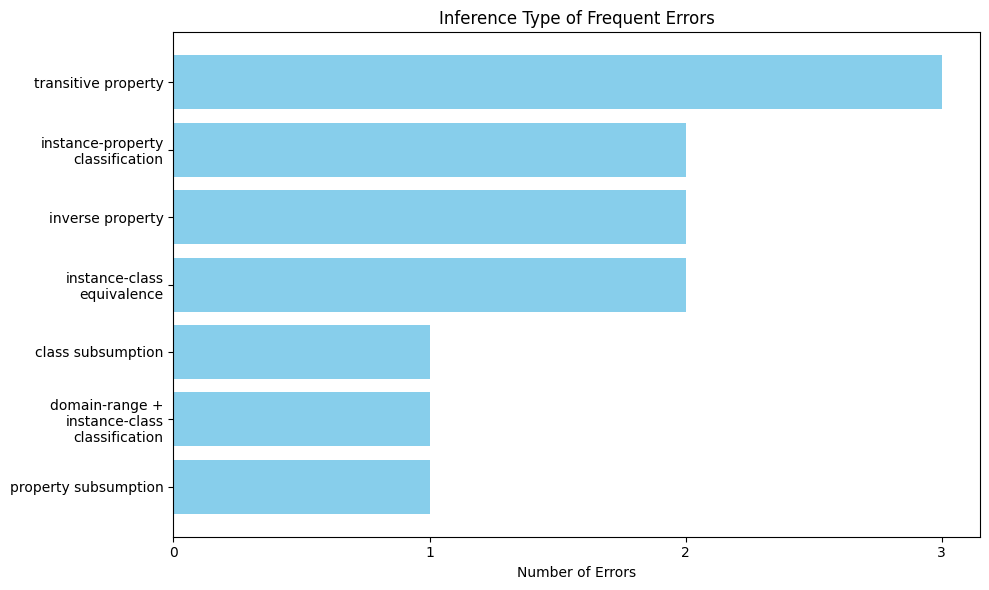

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import textwrap

# Example data
# sorted_values = ['Very long label that needs to be wrapped', 'Another label that is quite lengthy', 'Short label']
# sorted_counts = [25, 15, 10]

# Define the wrapping width
wrap_width = 20

# Wrap labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in sorted_values]

plt.figure(figsize=(10, 6))
plt.barh(wrapped_labels, sorted_counts, color='skyblue')
plt.xlabel('Number of Errors')
plt.title("Inference Type of Frequent Errors")
plt.gca().invert_yaxis()  # Most frequent on top
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [46]:
level1_len = len(newset_df[newset_df['level'] == 1])
level2_len = len(newset_df[newset_df['level'] == 2])
level3_len = len(newset_df[newset_df['level'] == 3])

level1_len,level2_len,level3_len


(29, 20, 4)

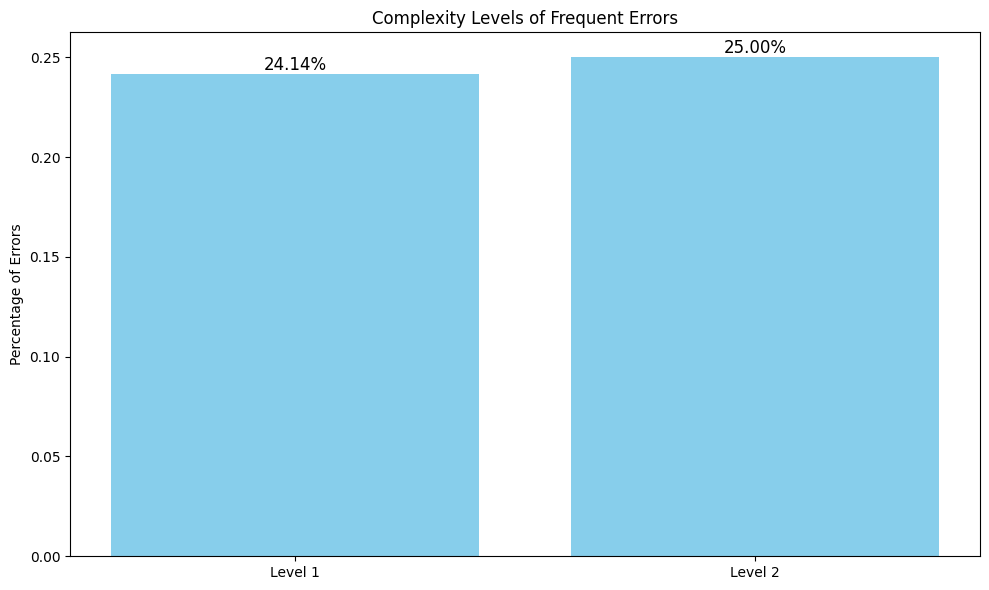

In [48]:
## distribuzione errori secondo inference type 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

types_count = np.unique(errors_info_df['level'], return_counts=True)
sorted_indices = np.argsort(-types_count[1])  

sorted_values = types_count[0][sorted_indices]
sorted_values = [f"Level {str(i)}" for i in sorted_values]
sorted_counts_not_norm = types_count[1][sorted_indices]

# Normalize (ensure correct division)
sorted_counts = [sorted_counts_not_norm[0]/level1_len, sorted_counts_not_norm[1]/level2_len]

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_values, sorted_counts, color='skyblue')

# Add text on top of bars
for bar, value in zip(bars, sorted_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.2%}', ha='center', va='bottom', fontsize=12)

plt.ylabel('Percentage of Errors')
plt.title("Complexity Levels of Frequent Errors")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


In [142]:
## transitive property errate: 
newset_df[newset_df['id'].isin([29,32,31,21])]

,premise,query,correct_answer,level,id,type,full_query
20,'Member Of' is a property,Is 'Is the Head Of' a subproperty of 'Member Of'?,Yes,1,21,property subsumption,'Member Of' is a property Is 'Is the Head Of' ...
28,X is part of Y. X is part of Z.,Is Y part of Z?,No,1,29,transitive property,X is part of Y. X is part of Z. Is Y part of Z?
30,X is part of Y. X is part of Z. Z is part of T,Is Y part of T?,Yes,2,31,transitive property,X is part of Y. X is part of Z. Z is part of T...
31,X is part of Y. X is part of Z. Z is part of T,Is T part of Y?,No,2,32,transitive property,X is part of Y. X is part of Z. Z is part of T...


In [143]:
## instance class equivalence errate (tutti hanno sbagliato su questa categoria)

newset_df[newset_df['id'].isin([11,13,14])]

 


,premise,query,correct_answer,level,id,type,full_query
10,X is person. X is taking Y. Y is a teaching co...,Is X a student?,Yes,1,11,instance-class equivalence,X is person. X is taking Y. Y is a teaching co...
12,X is an undergraduate student.,Is X taking a teaching course?,Yes,2,13,instance-class equivalence,X is an undergraduate student. Is X taking a t...
13,X is taking a teaching course.,Is X a student?,No,1,14,instance-class equivalence,X is taking a teaching course. Is X a student?


[7, 13, 18, 21, 31, 34, 49, 52, 7, 11, 13, 14, 15, 19, 22, 23, 25, 26, 32, 47, 50, 14, 26, 42, 7, 13, 14, 18, 21, 27, 29, 32, 40, 42, 6, 13, 14, 18, 21, 31, 32, 42, 6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]
domain-range: 5
instance-class equivalence: 4
inverse property: 4
property subsumption: 3
transitive property: 3
transitive property + instance-class classification + domain-range: 3
instance-property classification: 2
class subsumption: 2
domain-range + instance-class classification: 1


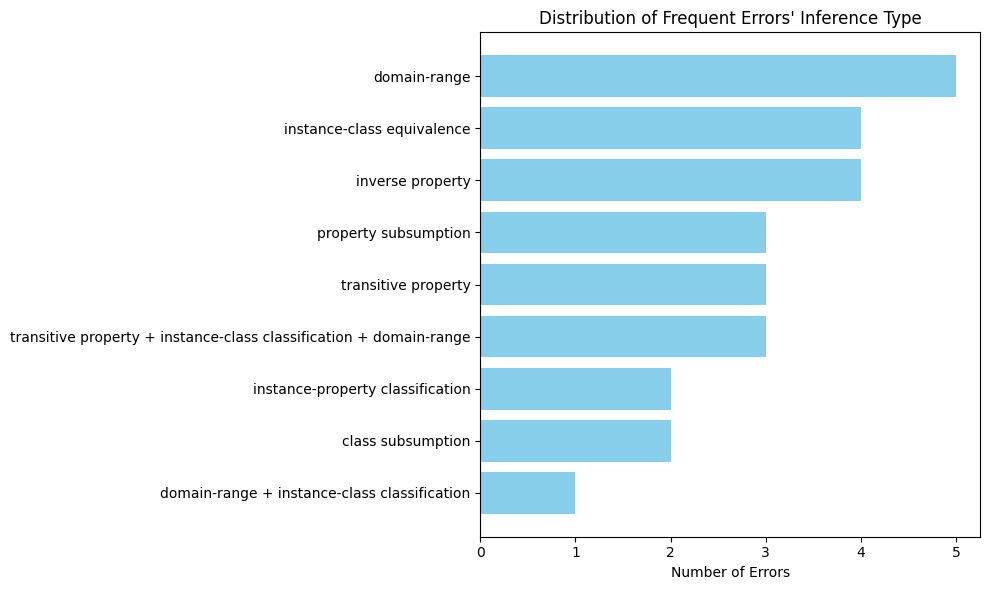

In [11]:
## distribuzione generale di inference types degli errori
from collections import Counter
all_errors = [err for sublist in models_errors_df['errors_id'] for err in sublist]
print(all_errors)
repeated_errors = {k: v for k, v in error_counts.items()}
# repeated_errors = [{int(i):v} for i,v in repeated_errors]
errors_info = []
for key, v in repeated_errors.items():
    # print("key  =", key)
    item = newset_df[newset_df['id']==key]
    error_type  = item['type']
    # print('error type = ' , error_type)
    # error_types.append(error_types)
    # error_levels.append(item['level'])

    error_info = {
        "id" : key, 
        "n_occurences" : v,
        "level" : item['level'].values[0], 
        "type"  : item['type'].values[0], 
        "query"  : item['full_query'].values[0], 

    }
    errors_info.append(error_info)
# np.uniqueerror_types, error_levels
errors_info_df = pd.DataFrame(errors_info)
# errors_info_df.to_csv("errors_info_experiment_no_premise.csv")
# errors_info_df
## distribuzione errori secondo inference type 
types_count = np.unique(errors_info_df['type'], return_counts=True)
sorted_indices = np.argsort(-types_count[1])  

# Apply sorted indices
sorted_values = types_count[0][sorted_indices]
sorted_counts = types_count[1][sorted_indices]

# Display
for value, count in zip(sorted_values, sorted_counts):
    print(f"{value}: {count}")
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(10, 6))
plt.barh(sorted_values, sorted_counts, color='skyblue')
plt.xlabel('Number of Errors')
plt.title("Distribution of Frequent Errors' Inference Type")
plt.gca().invert_yaxis()  # Most frequent on top
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [ ]:
# [7, 13, 18, 21, 31, 34, 49, 52, 7, 11, 13, 14, 15, 19, 22, 23, 25, 26, 32, 47, 50, 14, 26, 42, 7, 13, 14, 18, 21, 27, 29, 32, 40, 42, 6, 13, 14, 18, 21, 31, 32, 42, 6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]
# Errors appearing multiple times: {7: 4, 13: 5, 18: 3, 21: 4, 31: 2, 14: 4, 26: 3, 32: 4, 42: 4, 27: 2, 29: 2, 6: 2}

[7,
 13,
 18,
 21,
 31,
 34,
 49,
 52,
 7,
 11,
 13,
 14,
 15,
 19,
 22,
 23,
 25,
 26,
 32,
 47,
 50,
 14,
 26,
 42,
 7,
 13,
 14,
 18,
 21,
 27,
 29,
 32,
 40,
 42,
 6,
 13,
 14,
 18,
 21,
 31,
 32,
 42,
 6,
 7,
 13,
 21,
 24,
 26,
 27,
 29,
 32,
 38,
 39,
 42]

[7, 13, 18, 21, 31, 34, 49, 52, 7, 11, 13, 14, 15, 19, 22, 23, 25, 26, 32, 47, 50, 14, 26, 42, 7, 13, 14, 18, 21, 27, 29, 32, 40, 42, 6, 13, 14, 18, 21, 31, 32, 42, 6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]
Inference Type Distribution by Level:
transitive property: 3 total (Level 1: 1, Level 2: 2)
instance-property classification: 2 total (Level 1: 1, Level 2: 1)
instance-class equivalence: 2 total (Level 1: 1, Level 2: 1)
inverse property: 2 total (Level 1: 2)
class subsumption: 1 total (Level 1: 1)
domain-range + instance-class classification: 1 total (Level 2: 1)
property subsumption: 1 total (Level 1: 1)


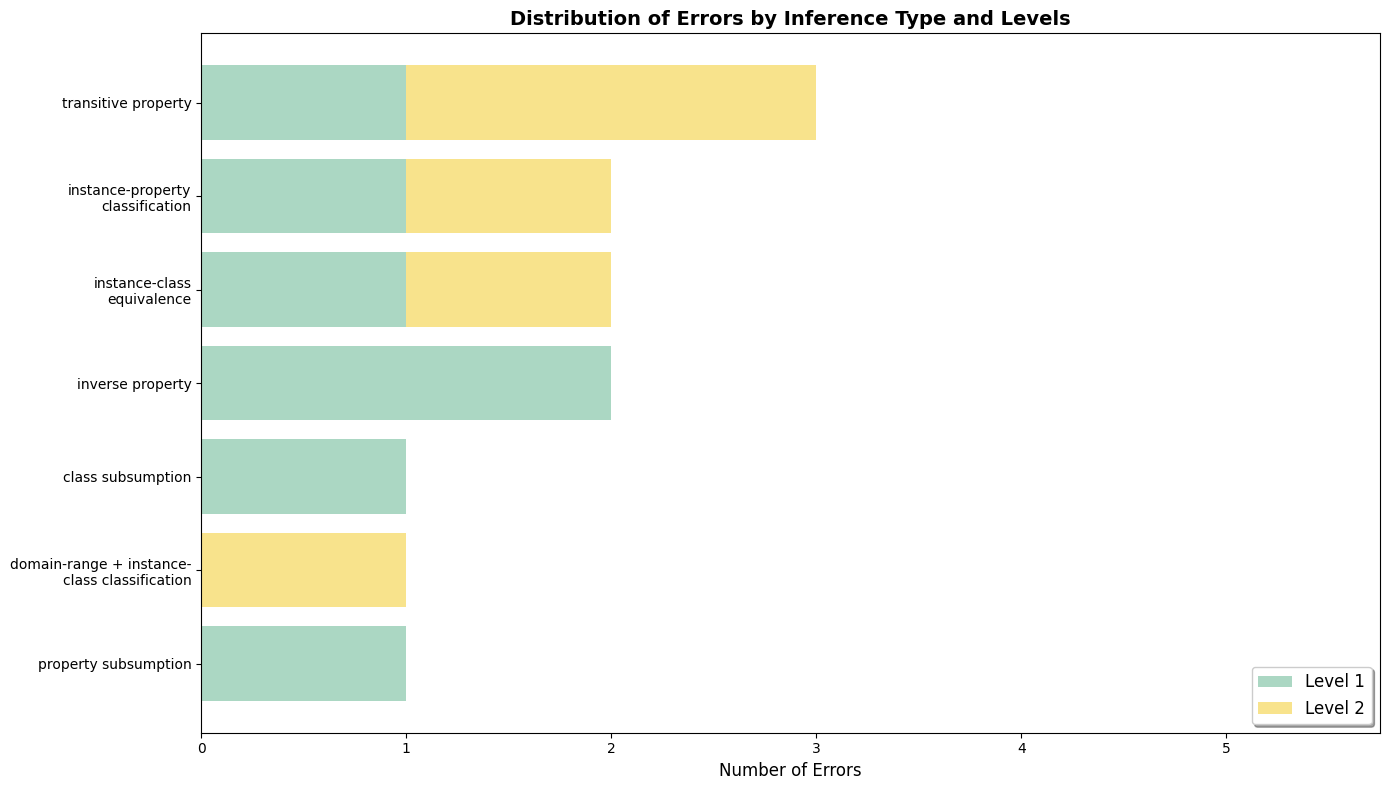

In [12]:
## distribuzione generale di inference types degli errori
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

all_errors = [err for sublist in models_errors_df['errors_id'] for err in sublist]
print(all_errors)
repeated_errors = {k: v for k, v in error_counts.items() if v>1}

errors_info = []
for key, v in repeated_errors.items():
    item = newset_df[newset_df['id']==key]
    error_info = {
        "id" : key, 
        "n_occurences" : v,
        "level" : item['level'].values[0], 
        "type"  : item['type'].values[0], 
        "query"  : item['full_query'].values[0], 
    }
    errors_info.append(error_info)

errors_info_df = pd.DataFrame(errors_info)

## distribuzione errori secondo inference type - stacked by level
import textwrap

# Group by type and level, count occurrences
type_level_counts = errors_info_df.groupby(['type', 'level']).size().unstack(fill_value=0)

# Sort by total count (descending)
type_totals = type_level_counts.sum(axis=1).sort_values(ascending=False)
type_level_counts = type_level_counts.loc[type_totals.index]

# Wrap long inference type names
wrapped_labels = []
for inf_type in type_level_counts.index:
    wrapped_label = '\n'.join(textwrap.wrap(str(inf_type), width=25))  # Adjust width as needed
    wrapped_labels.append(wrapped_label)

# Update the index with wrapped labels
type_level_counts.index = wrapped_labels

# Display summary
print("Inference Type Distribution by Level:")
for i, inf_type in enumerate(type_level_counts.index):
    original_type = type_totals.index[i]  # Get original unwrapped name
    total = type_totals.iloc[i]
    level_breakdown = ", ".join([f"Level {level}: {count}" for level, count in type_level_counts.iloc[i].items() if count > 0])
    print(f"{original_type}: {total} total ({level_breakdown})")

# Create stacked horizontal bar plot
fig, ax = plt.subplots(figsize=(14, 8))  # Increased width to accommodate wrapped labels

# Get all unique levels and create color mapping
all_levels = sorted(type_level_counts.columns)
colors = plt.cm.Set3(np.linspace(0, 1, len(all_levels)))
level_colors = dict(zip(all_levels, colors))

# Create stacked bars
left = np.zeros(len(type_level_counts))
bars_by_level = {}
custom_colors = {
    1: '#96CEB4',    # Green
    2: '#F7DC6F',    # Light Yellow
    8: '#DDA0DD',    # Plum
    4: '#FF6B6B',    # Red
    6: '#4ECDC4',    # Teal
    3: '#45B7D1',    # Blue
    5: '#FFEAA7',    # Yellow
    7: '#98D8E8',    # Light Blue
    # Add more colors as needed
}

# for level in all_levels:
#     if level in type_level_counts.columns:
#         bars = ax.barh(type_level_counts.index, type_level_counts[level], 
#                       left=left, label=f'Level {level}', 
#                       color=level_colors[level], alpha=0.8)
#         bars_by_level[level] = bars
#         left += type_level_counts[level]


level_colors = {}
for level in all_levels:
    if level in custom_colors:
        level_colors[level] = custom_colors[level]
    else:
        # Fallback color
        level_colors[level] = plt.cm.Set3(len(level_colors) / 10)

# Create sta
left = np.zeros(len(type_level_counts))
bars_by_level = {}

for level in all_levels:
    if level in type_level_counts.columns:
        bars = ax.barh(type_level_counts.index, type_level_counts[level], 
                      left=left, label=f'Level {level}', 
                      color=level_colors[level], alpha=0.8)
        bars_by_level[level] = bars
        left += type_level_counts[level]
ax.set_xlabel('Number of Errors', fontsize=12)
# ax.set_ylabel('Inference Type', fontsize=12)
ax.set_title("Distribution of Errors by Inference Type and Levels", fontsize=14, fontweight='bold')
ax.set_xlim(0, 5 * 1.15)  # Add 15% padding to the right

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.invert_yaxis()  # Most frequent on top

# Add legend
ax.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True)

# # Add total count labels at the end of each bar
# for i, (inf_type, total) in enumerate(type_totals.items()):
#     ax.text(total + 0.5, i, str(total), va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [50]:
## levels distributions in newset 
level1_len/len(newset_df),level2_len/len(newset_df),level3_len/len(newset_df),

(0.5471698113207547, 0.37735849056603776, 0.07547169811320754)

In [ ]:
### analisi istanze transitive property: transitive property 
## ist 29 - risposta corretta = no "premise": "X is part of Y. X is part of Z.",# "query": "Is Y part of Z?",
for file in os.listdir("./results/results_newset"):
    if "premise" not in file and ".json" not in file and "full" not in file:
        # print(file)
        _model = file.split(".csv")[0]
        # create_report
        _df_results = pd.read_csv(f"./results/results_newset/{file}")
        row = _df_results[_df_results['id'] == 29]

        res = "correct" if row.at[row.index[0], 'discrete_answer'] == row.at[row.index[0], 'correct_answer'] else "produced error"
        print(f"expl 29 - model {_model} - result: {res}: \n",_df_results[_df_results['id'] == 29]['thoughts'].values , "\n")

# models_errors_df = pd.DataFrame(models_errors)


expl 29 - model deepseek_distil_llama - result: correct: 
 ["In the LUBM ontology, the 'partOf' property is used to represent part-whole relationships. If X is part of both Y and Z, it implies that Y and Z are both larger entities that X is a part of. However, the LUBM ontology does not provide a direct axiom that would necessarily make Y part of Z simply because X is part of both. The relationships between Y and Z would depend on the specific structure defined in the ontology, and without additional information, we cannot conclude that Y is part of Z."] 

expl 29 - model llama3_1_8b - result: correct: 
 ["To answer this question, we need to analyze the transitive property in the LUBM ontology. The query implies a relation of 'part_of' between entities. We must check if there's a transitive property defined for 'part_of' in the ontology that would allow us to infer Y is part of Z based on X being part of both."] 

expl 29 - model llama4 - result: correct: 
 ["The LUBM ontology defines 

In [ ]:
'''
Figure X analyze the errors distribution according to the inference type. 
'''

In [ ]:
## 14 l'ha sbaglaita anche llama4.
############## E' un trabocchetto perchè X non è definita come person. #####################
print("explanation llama4 on instance id 14 : \n", llama4_results[llama4_results['id'] ==14 ]['thoughts'].values)

explanation llama4 on instance id 14 : 
 ['In the LUBM ontology, a Student is defined as a Person who takesCourse some Course. Since X is taking a teaching course, and a teaching course is a subclass of Course, X satisfies the condition of taking a Course. Therefore, X can be classified as a Student.']


err0r types for model : deepseek_distil_llama - error types: 6                      instance-property classification
12                           instance-class equivalence
17                                    class subsumption
20                                 property subsumption
30                                  transitive property
33                                         domain-range
48    transitive property + instance-class classific...
51                                         domain-range
Name: type, dtype: object
err0r types for model : llama3_1_8b - error types: 6                      instance-property classification
10                           instance-class equivalence
12                           instance-class equivalence
13                           instance-class equivalence
14                           instance-class equivalence
18                                    class subsumption
21                                 property subsumption
22                    

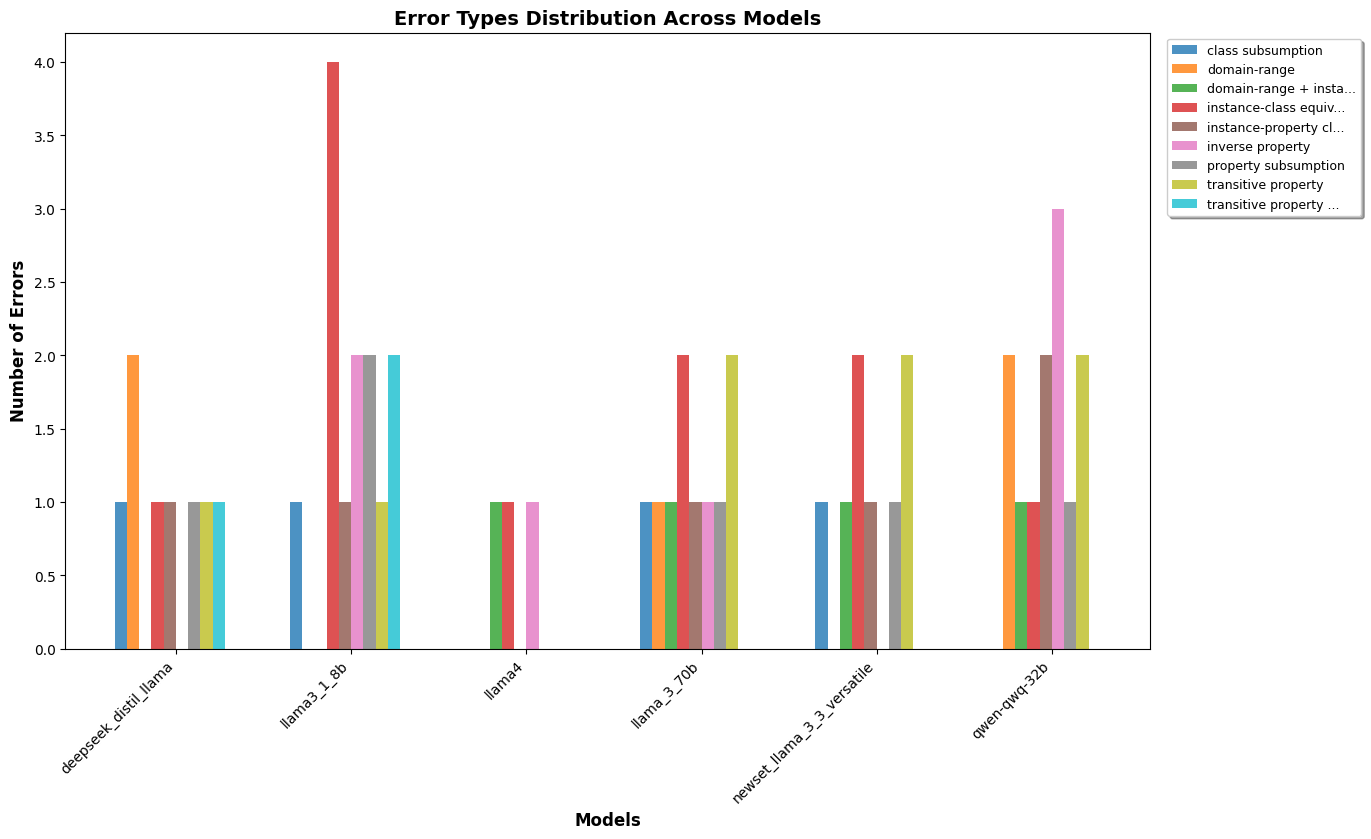

In [ ]:
## distr errori in base ai modelli 
def create_clean_error_visualization(df):
    """
    Create a single, clean visualization with proper legend
    """
    # Process data
    model_error_counts = {}
    all_error_types = set()
    
    for idx, row in df.iterrows():
        # print("row = ", row)
        model = row['model']
        error_types = row['errors types']
        error_counter = Counter(error_types)
        print(f'err0r types for model : {model} - error types: {error_types}')
        model_error_counts[model] = error_counter
        all_error_types.update(error_types)
    
    all_error_types = sorted(list(all_error_types))
    
    # Create matrix
    error_matrix = []
    model_names = list(model_error_counts.keys())
    
    for model in model_names:
        row = [model_error_counts[model].get(error_type, 0) for error_type in all_error_types]
        error_matrix.append(row)
    print(error_matrix)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    error_matrix_np = np.array(error_matrix)
    x = np.arange(len(model_names))
    width = 0.07
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_error_types)))
    
    # Create grouped bars
    for i, error_type in enumerate(all_error_types):
        counts = error_matrix_np[:, i]
        offset = (i - len(all_error_types)/2) * width
        ax.bar(x + offset, counts, width, label=error_type[:20] + '...' if len(error_type) > 20 else error_type, 
               color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
    ax.set_title('Error Types Distribution Across Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    
    # Create legend outside the plot
    # ax.legend(bbox_to_anchor=(1, 1),handlelength=1, loc='upper right', fontsize=8)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9, 
              frameon=True, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()

create_clean_error_visualization(models_errors_df)

error types for model: deepseek_distil_llama - error types: 6                      instance-property classification
12                           instance-class equivalence
17                                    class subsumption
20                                 property subsumption
30                                  transitive property
33                                         domain-range
48    transitive property + instance-class classific...
51                                         domain-range
Name: type, dtype: object
error types for model: llama3_1_8b - error types: 6                      instance-property classification
10                           instance-class equivalence
12                           instance-class equivalence
13                           instance-class equivalence
14                           instance-class equivalence
18                                    class subsumption
21                                 property subsumption
22                      

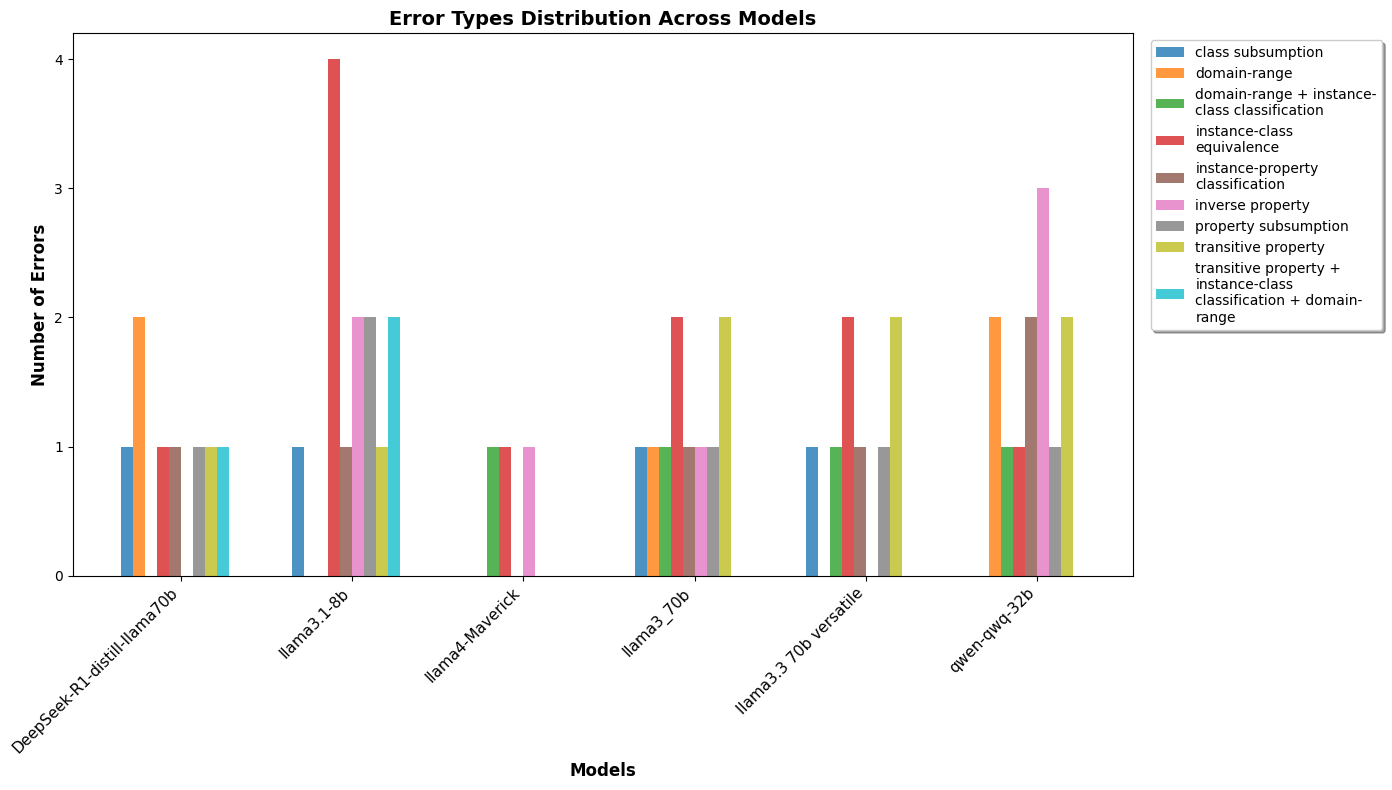

In [103]:

# Alternative version with wrapped text in legend
def create_clean_error_visualization_v3(df):
    """
    Create visualization with text wrapping in legend labels
    """
    import textwrap
    
    # Process data (same as above)
    model_error_counts = {}
    all_error_types = set()
    
    for idx, row in df.iterrows():
        model = row['model']
        error_types = row['errors types']
        error_counter = Counter(error_types)
        print(f'error types for model: {model} - error types: {error_types}')
        model_error_counts[model] = error_counter
        all_error_types.update(error_types)
    
    all_error_types = sorted(list(all_error_types))
    
    # Create matrix
    error_matrix = []
    model_names = list(model_error_counts.keys())
    
    for model in model_names:
        row = [model_error_counts[model].get(error_type, 0) for error_type in all_error_types]
        error_matrix.append(row)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    error_matrix_np = np.array(error_matrix)
    x = np.arange(len(model_names))
    width = 0.07
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_error_types)))
    
    # Create grouped bars with wrapped labels
    wrapped_labels = []
    for i, error_type in enumerate(all_error_types):
        counts = error_matrix_np[:, i]
        offset = (i - len(all_error_types)/2) * width
        
        # Wrap long labels
        wrapped_label = '\n'.join(textwrap.wrap(error_type, width=25))
        wrapped_labels.append(wrapped_label)
        
        ax.bar(x + offset, counts, width, label=wrapped_label, 
               color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
    ax.set_title('Error Types Distribution Across Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    model_names = ['DeepSeek-R1-distill-llama70b', 'llama3.1-8b','llama4-Maverick','llama3_70b', 'llama3.3 70b versatile','qwen-qwq-32b']
    ax.set_xticklabels(model_names, rotation=45, ha='right',fontsize=11)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    
    # OPTION 3: Legend with wrapped text
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, 
              frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.7)  # More space for wrapped text
    plt.show()

# Use the original function with modifications
create_clean_error_visualization_v3(models_errors_df)

In [ ]:
'''
tutti hanno almeno un errore in instance-class equivalence. soprattutto llama 31 8b 
tutti i modelli tranne llama4 hanno commesso errori su transitive property
4/5 sbagliano inverse property
3/5 errori su domain - range'''

error types for model: deepseek_distil_llama - error types: ['instance-property classification' 'instance-class equivalence'
 'class subsumption' 'property subsumption' 'transitive property'
 'domain-range'
 'transitive property + instance-class classification + domain-range'
 'domain-range']
error types for model: llama3_1_8b - error types: ['instance-property classification' 'instance-class equivalence'
 'instance-class equivalence' 'class subsumption' 'property subsumption'
 'property subsumption' 'property subsumption' 'inverse property'
 'inverse property' 'transitive property' 'transitive property'
 'transitive property' 'domain-range'
 'domain-range + instance-class classification'
 'instance-class equivalence + instance-class classification'
 'transitive property + instance-class classification + domain-range'
 'transitive property + instance-class classification + domain-range'
 'domain-range' 'domain-range']
error types for model: llama4 - error types: ['instance-class equiva

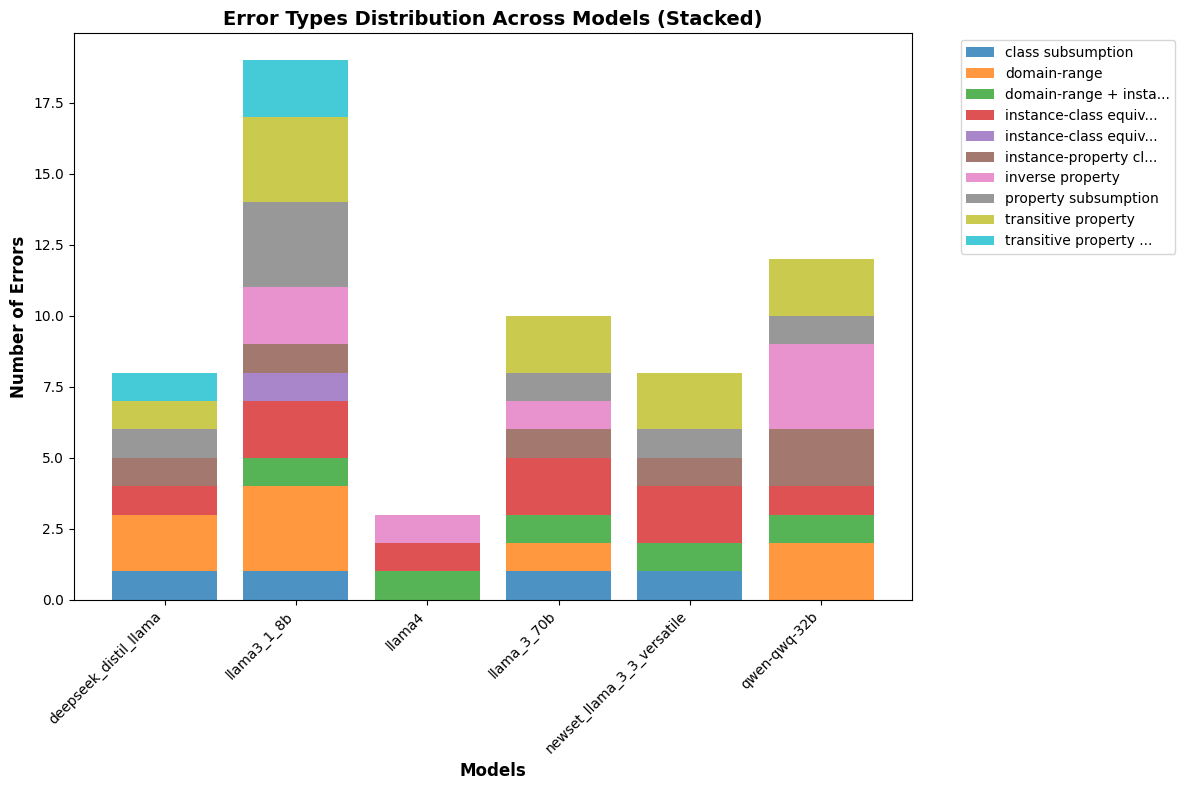

In [109]:
def create_stacked_error_visualization(df):
    """
    Create a stacked bar chart - eliminates spacing issues completely
    """
    # Process data
    model_error_counts = {}
    all_error_types = set()
    
    for idx, row in df.iterrows():
        model = row['model']
        error_types = row['errors types']
        error_counter = Counter(error_types)
        print(f'error types for model: {model} - error types: {error_types}')
        model_error_counts[model] = error_counter
        all_error_types.update(error_types)
    
    all_error_types = sorted(list(all_error_types))
    
    # Create matrix
    error_matrix = []
    model_names = list(model_error_counts.keys())
    
    for model in model_names:
        row = [model_error_counts[model].get(error_type, 0) for error_type in all_error_types]
        error_matrix.append(row)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    error_matrix_np = np.array(error_matrix)
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_error_types)))
    
    # Create stacked bars
    bottom = np.zeros(len(model_names))
    
    for i, error_type in enumerate(all_error_types):
        counts = error_matrix_np[:, i]
        # Only create bars where count > 0
        if np.any(counts > 0):
            ax.bar(model_names, counts, bottom=bottom, 
                  label=error_type[:20] + '...' if len(error_type) > 20 else error_type, 
                  color=colors[i], alpha=0.8)
            bottom += counts
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
    ax.set_title('Error Types Distribution Across Models (Stacked)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Create legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
create_stacked_error_visualization(models_errors_df)

In [97]:
models_errors_df

,model,correct_id,errors_id,accuracy,errors types
0,deepseek_distil_llama,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 1...","[7, 13, 18, 21, 31, 34, 49, 52]",0.85,"[instance-property classification, instance-cl..."
1,llama3_1_8b,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 16, 1...","[6, 11, 14, 19, 20, 21, 23, 26, 27, 29, 32, 33...",0.64,"[instance-property classification, instance-cl..."
2,llama4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...","[14, 26, 42]",0.94,"[instance-class equivalence, inverse property,..."
3,llama_3_70b,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 1...","[7, 13, 14, 18, 21, 27, 29, 32, 40, 42]",0.79,"[instance-property classification, instance-cl..."
4,newset_llama_3_3_versatile,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 1...","[6, 13, 14, 18, 21, 31, 32, 42]",0.85,"[instance-property classification, instance-cl..."
5,qwen-qwq-32b,"[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, ...","[6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]",0.77,"[instance-property classification, instance-pr..."


In [98]:
newset_df

,premise,query,correct_answer,level,id,type,full_query
0,X is a student.,Is X a person?,Yes,1,1,instance-class classification,X is a student. Is X a person?
1,X is a faculty member.,Is X a person?,Yes,2,2,instance-class classification,X is a faculty member. Is X a person?
2,X is a person.,Is X an employee?,No,1,3,instance-class classification,X is a person. Is X an employee?
3,X is a work.,Is X a graduate level course?,No,2,4,instance-class classification,X is a work. Is X a graduate level course?
4,X works for Y.,Is X a member of Y?,Yes,1,5,instance-property classification,X works for Y. Is X a member of Y?
5,X is the head of Y.,Is X a member of Y?,Yes,2,6,instance-property classification,X is the head of Y. Is X a member of Y?
6,X is a member of Y.,Does X work for Y?,No,1,7,instance-property classification,X is a member of Y. Does X work for Y?
7,X is a member of Y.,Is X the head of Y?,No,2,8,instance-property classification,X is a member of Y. Is X the head of Y?
8,X is person. X works for Y. Y is an organization.,Is X an employee?,Yes,1,9,instance-class equivalence,X is person. X works for Y. Y is an organizati...
9,X is person.,Is X a chair?,No,1,10,instance-class equivalence,X is person. Is X a chair?


#### analisi delle explanations

In [85]:
# per errore che appare più volte: id 21  - risposta corretta = si 
## errori comuni (exp senza premise)

for file in os.listdir("./results/results_newset"):
    if "premise" not in file and ".json" not in file and "full" not in file:
        # print(file)
        _model = file.split(".csv")[0]
        # create_report
        _df_results = pd.read_csv(f"./results/results_newset/{file}")
        row = _df_results[_df_results['id'] == 21]

        res = "correct" if row.at[row.index[0], 'discrete_answer'] == row.at[row.index[0], 'correct_answer'] else "produced error"
        print(f"expl 21 - model {_model} - result: {res}: \n",_df_results[_df_results['id'] == 21]['thoughts'].values , "\n")

models_errors_df = pd.DataFrame(models_errors)


expl 21 - model deepseek_distil_llama - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', I need to check if there is a subproperty axiom in the LUBM ontology that defines 'Is the Head Of' as a subproperty of 'Member Of'."] 

expl 21 - model llama3_1_8b - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', we need to analyze their definitions and relationships within the LUBM ontology."] 

expl 21 - model llama4 - result: correct: 
 ["The LUBM ontology defines the 'headOf' property as a subproperty of 'worksFor', and 'worksFor' is a subproperty of 'memberOf'. Therefore, 'headOf' is indirectly a subproperty of 'memberOf'."] 

expl 21 - model llama_3_70b - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', I need to check the subproperty axioms in the LUBM ontology. Specifically, I'll look for a subPropertyOf axiom that relates 'Is the Head Of' to 'Member Of'."

In [ ]:
'''COMMENTO RISULTATI 
il modello Llama 4 ragione correttamente con un ragionamento multi steps. 

Gli altri modelli falliscono nell'attuare il ragionamento; si limitano alla descrizione del task. 
Deepseek è molto simile al modello su cui è distilled (llama370b)
Modello llama3.1 8b molto vago (we need to analyze their definitions and relationships within the LUBM ontology.) non cita relazioni specifiche

llama3.3 70b versatile spiega più nel dettaglio la logica del task ma si ferma comunque a spiegazione del task 

qwen-32b vede gli assiomi ma non produce istanza e la risposta non è coerente con il ragionamento.

'''

## analisi errori exp con premise

In [35]:
## errori comuni (exp senza premise)
from sklearn.metrics import accuracy_score
models_errors_premise = []
for file in os.listdir("./results/results_newset"):
    if "premise" in file and ".json" not in file and "full" not in file:
        # print(file)
        _model = file.split(".csv")[0]
        print("model =", _model)
        # create_report
        _df_results = pd.read_csv(f"./results/results_newset/{file}")
        model_correct_id, model_errors_id = create_report(results_df=_df_results, full_queries_df=newset_df)
        errors_subset = newset_df[newset_df['id'].isin(model_errors_id)]['type']
        models_errors_premise.append(
            {
                "model" : _model,
                "correct_id" : model_correct_id,#.values, 
                "errors_id" : model_errors_id,#.values,
                "accuracy" : round(accuracy_score(_df_results['correct_answer'], _df_results['discrete_answer']),2),
                "errors types" : errors_subset,#.values
            }
        )
models_errors_premise_df = pd.DataFrame(models_errors_premise)


model = deepseek_llama_premise
model accuracy:  0.8490566037735849 sample size:  53
valid answers:  53
model accuracy not considering errors:  0.8490566037735849 sample size:  53
level:  1 error:  4
level:  2 error:  4
inference type:  class subsumption correct instances:  1
inference type:  domain-range correct instances:  2
inference type:  instance-class equivalence correct instances:  2
inference type:  instance-property classification correct instances:  1
inference type:  property subsumption correct instances:  1
inference type:  transitive property correct instances:  1
level:  1 correct instances:  26
level:  2 correct instances:  15
level:  3 correct instances:  3
inference type:  class subsumption correct instances:  3
inference type:  domain-range correct instances:  6
inference type:  domain-range + instance-class classification correct instances:  4
inference type:  instance-class classification correct instances:  4
inference type:  instance-class equivalence correct ins

In [36]:
models_errors_premise_df
## premise ha migliorato llama3.18b - anche facendo generare meno errori - e qwen-qwq-32b che sono i modelli con meno parametri rispetto agli altri

,model,correct_id,errors_id,accuracy,errors types
0,deepseek_llama_premise,0 1 1 2 2 3 3 4 4 5 6...,"[6, 13, 14, 18, 21, 31, 38, 52]",0.85,5 instance-property classification 12 ...
1,llama3_1_8b_premise,0 1 1 2 4 5 5 6 6 7 8...,"[3, 4, 8, 13, 18, 26, 27, 29, 32, 33, 41, 46]",0.75,2 instance-class class...
2,llama3_70b_premise,0 1 1 2 2 3 3 4 4 5 5...,"[7, 13, 14, 17, 26, 27, 29, 32, 38, 42, 47]",0.79,6 instance-property class...
3,llama4_premise,0 1 1 2 2 3 3 4 4 5 5...,"[13, 14, 31, 38, 42, 47, 52]",0.87,12 instance-class eq...
4,new_instructions_llama_3_3_versatile_premise,0 1 1 2 2 3 3 4 6 7 7...,"[5, 6, 13, 14, 18, 21, 31, 38, 47]",0.83,4 instance-property class...
5,qwen-qwq-32b_premise,0 1 1 2 2 3 3 4 5 6 6...,"[5, 13, 14, 18, 21, 22, 31, 38, 48, 52]",0.81,4 instance-property class...


In [37]:
from collections import Counter


# Flatten all error IDs into a single list
all_errors_premise = [err for sublist in models_errors_premise_df['errors_id'] for err in sublist]
print(all_errors_premise)
# Count occurrences
error_counts_premise = Counter(all_errors_premise)

# Filter only those appearing more than once
repeated_errors_premise = {k: v for k, v in error_counts_premise.items() if v > 1}
# repeated_errors_premise = [{int(i):v} for i,v in repeated_errors_premise]
print("Errors appearing multiple times:", repeated_errors_premise)

[6, 13, 14, 18, 21, 31, 38, 52, 3, 4, 8, 13, 18, 26, 27, 29, 32, 33, 41, 46, 7, 13, 14, 17, 26, 27, 29, 32, 38, 42, 47, 13, 14, 31, 38, 42, 47, 52, 5, 6, 13, 14, 18, 21, 31, 38, 47, 5, 13, 14, 18, 21, 22, 31, 38, 48, 52]
Errors appearing multiple times: {6: 2, 13: 6, 14: 5, 18: 4, 21: 3, 31: 4, 38: 5, 52: 3, 26: 2, 27: 2, 29: 2, 32: 2, 42: 2, 47: 3, 5: 2}


In [38]:
repeated_errors_premise

{6: 2,
 13: 6,
 14: 5,
 18: 4,
 21: 3,
 31: 4,
 38: 5,
 52: 3,
 26: 2,
 27: 2,
 29: 2,
 32: 2,
 42: 2,
 47: 3,
 5: 2}

In [39]:
errors_info_premise = []
for key, v in repeated_errors_premise.items():
    # print("key  =", key)
    item = newset_df[newset_df['id']==key]
    error_type  = item['type']
    # print('error type = ' , error_type)
    # error_types.append(error_types)
    # error_levels.append(item['level'])

    error_info = {
        "id" : key, 
        "n_occurences" : v,
        "level" : item['level'].values[0], 
        "type"  : item['type'].values[0], 
        "query"  : item['full_query'].values[0], 

    }
    errors_info_premise.append(error_info)
# np.uniqueerror_types, error_levels
errors_info_premise_df = pd.DataFrame(errors_info_premise)

In [40]:
errors_info_premise_df.to_csv("errors_info_experiment_WITH_premise.csv")

In [41]:
errors_info_premise_df

,id,n_occurences,level,type,query
0,6,2,2,instance-property classification,X is the head of Y. Is X a member of Y?
1,13,6,2,instance-class equivalence,X is an undergraduate student. Is X taking a t...
2,14,5,1,instance-class equivalence,X is taking a teaching course. Is X a student?
3,18,4,1,class subsumption,'Work' is a class Is 'Graduate Level Courses' ...
4,21,3,1,property subsumption,'Member Of' is a property Is 'Is the Head Of' ...
5,31,4,2,transitive property,X is part of Y. X is part of Z. Z is part of T...
6,38,5,1,domain-range,X has a research project Y. Y is a research wo...
7,52,3,2,domain-range,X has a member Y. Y is about Z. Is Y a person?
8,26,2,1,inverse property,X is member of Y. Does Y have as alumns X?
9,27,2,1,inverse property,X has a degree from Y. Does Y have member X?


In [42]:
## distribuzione errori secondo inference type 
types_count_premise = np.unique(errors_info_premise_df['type'], return_counts=True)
sorted_indices = np.argsort(-types_count_premise[1])  

# Apply sorted indices
sorted_values = types_count_premise[0][sorted_indices]
sorted_counts = types_count_premise[1][sorted_indices]

# Display
for value, count in zip(sorted_values, sorted_counts):
    print(f"{value}: {count}")

transitive property: 3
domain-range: 2
instance-property classification: 2
instance-class equivalence: 2
inverse property: 2
class subsumption: 1
domain-range + instance-class classification: 1
property subsumption: 1
transitive property + instance-class classification + domain-range: 1


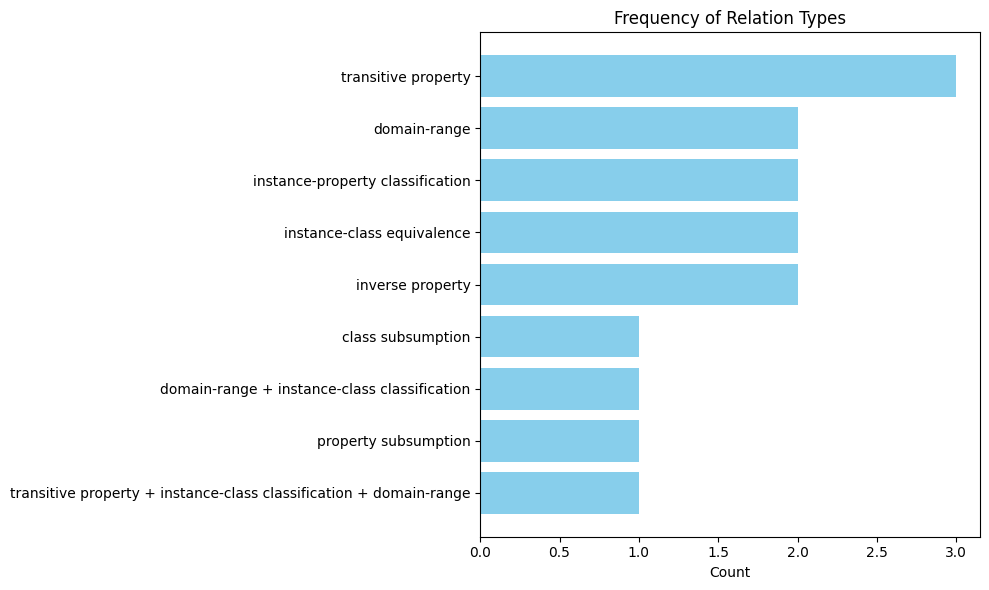

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(sorted_values, sorted_counts, color='skyblue')
plt.xlabel('Count')
plt.title('Frequency of Relation Types')
plt.gca().invert_yaxis()  # Most frequent on top
plt.tight_layout()
plt.show()

error types for model: deepseek_llama_premise - error types: 5     instance-property classification
12          instance-class equivalence
13          instance-class equivalence
17                   class subsumption
20                property subsumption
30                 transitive property
37                        domain-range
51                        domain-range
Name: type, dtype: object
error types for model: llama3_1_8b_premise - error types: 2                         instance-class classification
3                         instance-class classification
7                      instance-property classification
12                           instance-class equivalence
17                                    class subsumption
25                                     inverse property
26                                     inverse property
28                                  transitive property
31                                  transitive property
32                                  tra

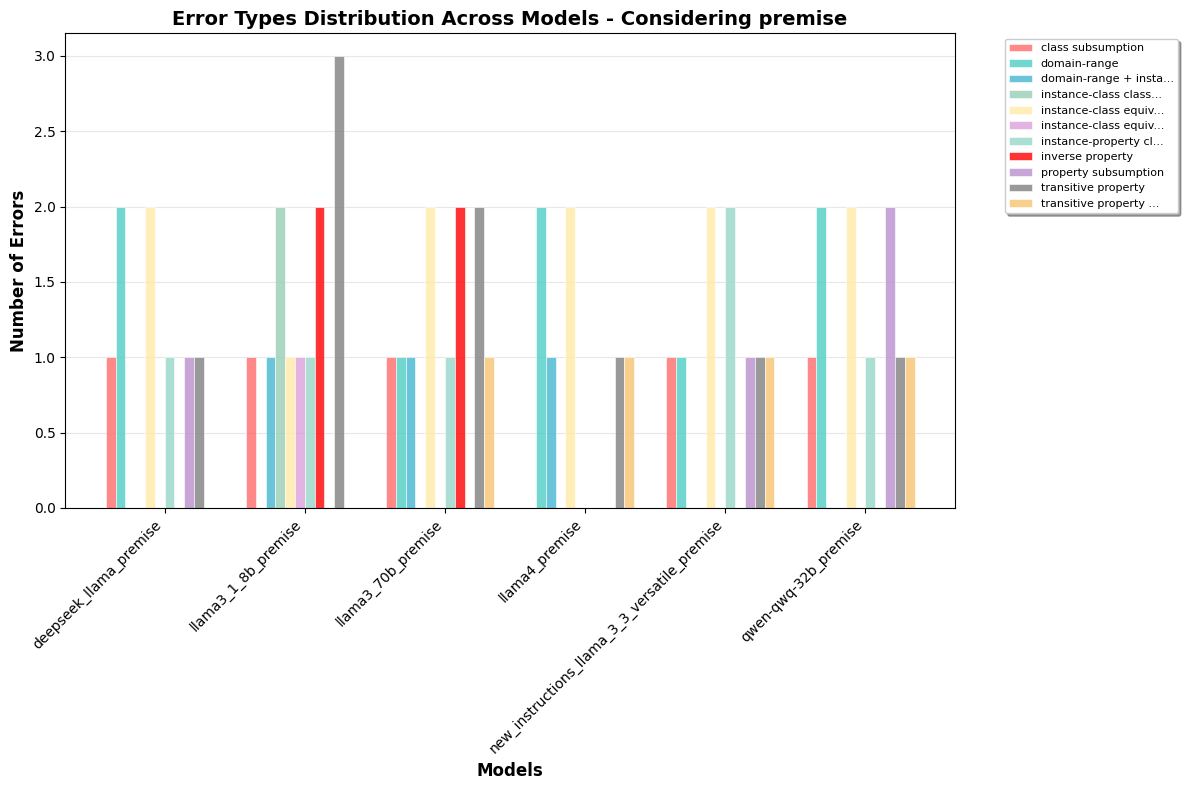

In [46]:
## distr errori in base ai modelli 
def create_clean_error_visualization(df):
    """
    Create a single, clean visualization with custom colors
    """
    # Process data
    model_error_counts = {}
    all_error_types = set()
    
    for idx, row in df.iterrows():
        model = row['model']
        error_types = row['errors types']
        error_counter = Counter(error_types)
        print(f'error types for model: {model} - error types: {error_types}')
        model_error_counts[model] = error_counter
        all_error_types.update(error_types)
    
    all_error_types = sorted(list(all_error_types))
    
    # Define custom colors - you can modify these as needed
    custom_colors = [
        '#FF6B6B',  # Red
        '#4ECDC4',  # Teal
        '#45B7D1',  # Blue
        '#96CEB4',  # Mint Green
        '#FFEAA7',  # Yellow
        '#DDA0DD',  # Plum
        '#98D8C8',  # Mint
        'red',  # Light Yellow
        '#BB8FCE',  # Light Purple
        'gray',  # Light Blue
        '#F8C471',  # Orange
        '#82E0AA',  # Light Green
        '#F1948A',  # Light Red
        '#AED6F1',  # Sky Blue
        '#D7BDE2',  # Lavender
    ]
    
    # If you have more error types than colors, extend the color list
    if len(all_error_types) > len(custom_colors):
        # Fall back to matplotlib's color cycle for additional colors
        additional_colors = plt.cm.tab10(np.linspace(0, 1, len(all_error_types) - len(custom_colors)))
        custom_colors.extend([tuple(color) for color in additional_colors])
    
    # Trim colors to match the number of error types
    colors = custom_colors[:len(all_error_types)]
    
    # Create matrix
    error_matrix = []
    model_names = list(model_error_counts.keys())
    
    for model in model_names:
        row = [model_error_counts[model].get(error_type, 0) for error_type in all_error_types]
        error_matrix.append(row)
    print(error_matrix)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    error_matrix_np = np.array(error_matrix)
    x = np.arange(len(model_names))
    width = 0.07
    
    # Create grouped bars with custom colors
    for i, error_type in enumerate(all_error_types):
        counts = error_matrix_np[:, i]
        offset = (i - len(all_error_types)/2) * width
        ax.bar(x + offset, counts, width, 
               label=error_type[:20] + '...' if len(error_type) > 20 else error_type, 
               color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
    ax.set_title('Error Types Distribution Across Models - Considering premise', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Create legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, 
              frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

create_clean_error_visualization(models_errors_premise_df)

error types for model: deepseek_llama_premise - error types: 5     instance-property classification
12          instance-class equivalence
13          instance-class equivalence
17                   class subsumption
20                property subsumption
30                 transitive property
37                        domain-range
51                        domain-range
Name: type, dtype: object
error types for model: llama3_1_8b_premise - error types: 2                         instance-class classification
3                         instance-class classification
7                      instance-property classification
12                           instance-class equivalence
17                                    class subsumption
25                                     inverse property
26                                     inverse property
28                                  transitive property
31                                  transitive property
32                                  tra

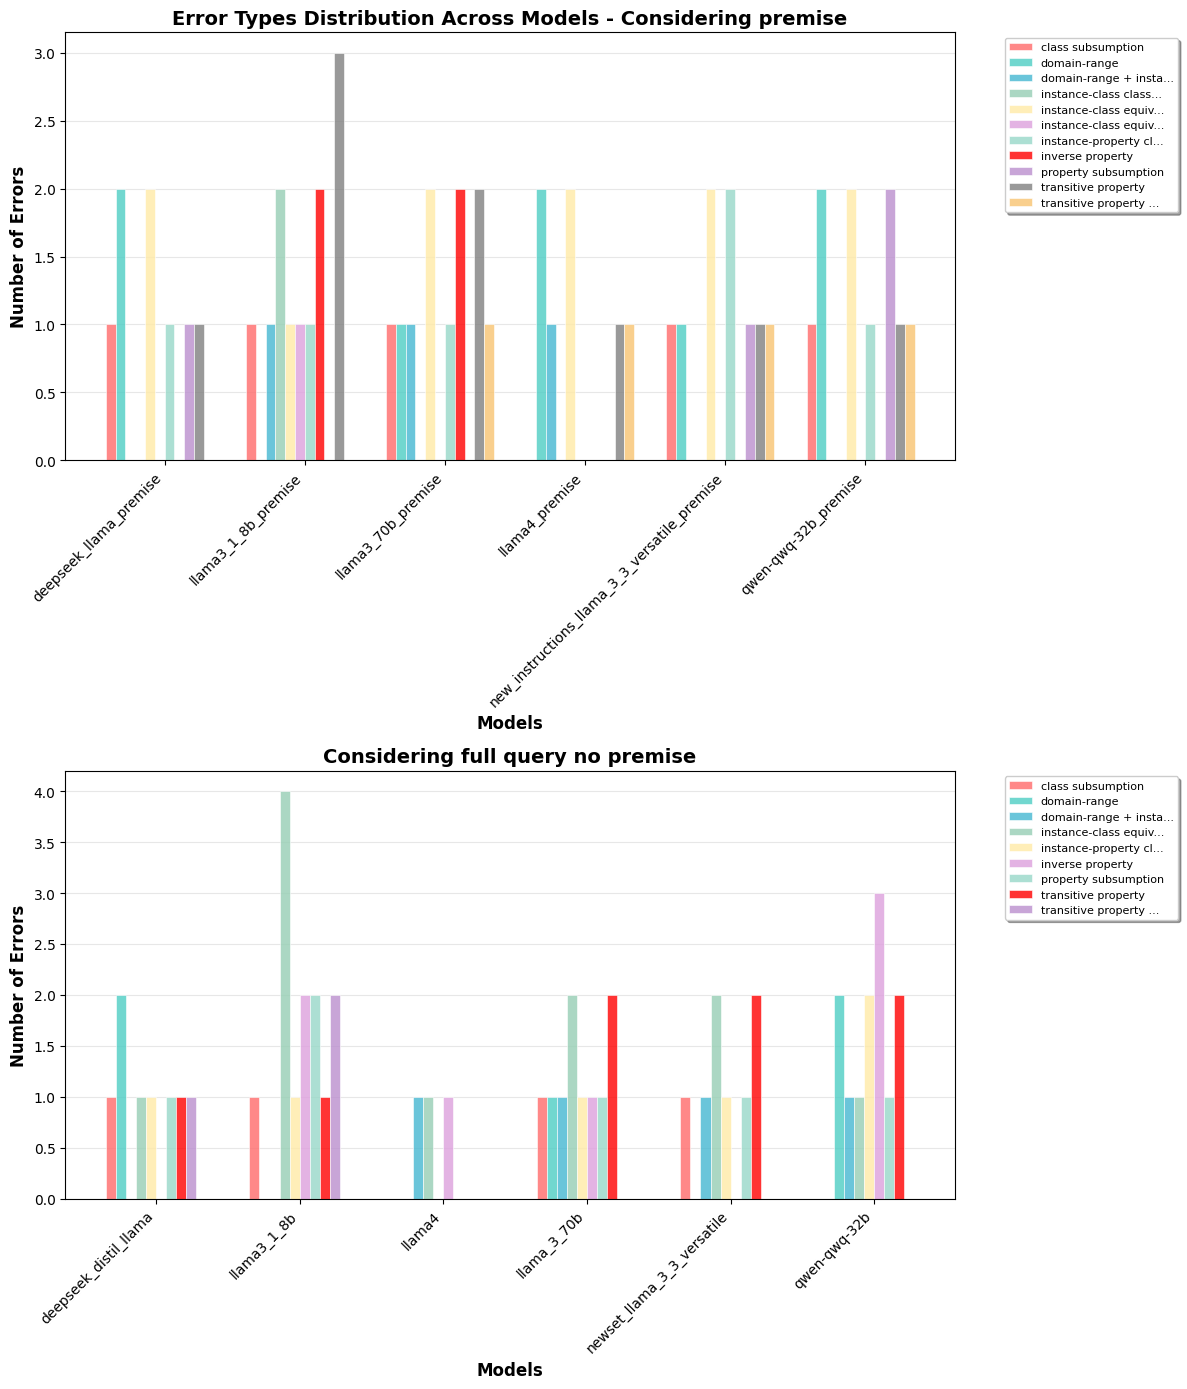

In [63]:
## confornto 

## distr errori in base ai modelli 
def create_clean_error_visualization(df,title = "", ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    # Process data
    model_error_counts = {}
    all_error_types = set()
    
    for idx, row in df.iterrows():
        model = row['model']
        error_types = row['errors types']
        error_counter = Counter(error_types)
        print(f'error types for model: {model} - error types: {error_types}')
        model_error_counts[model] = error_counter
        all_error_types.update(error_types)
    
    all_error_types = sorted(list(all_error_types))
    
    # Define custom colors - you can modify these as needed
    custom_colors = [
        '#FF6B6B',  # Red
        '#4ECDC4',  # Teal
        '#45B7D1',  # Blue
        '#96CEB4',  # Mint Green
        '#FFEAA7',  # Yellow
        '#DDA0DD',  # Plum
        '#98D8C8',  # Mint
        'red',  # Light Yellow
        '#BB8FCE',  # Light Purple
        'gray',  # Light Blue
        '#F8C471',  # Orange
        '#82E0AA',  # Light Green
        '#F1948A',  # Light Red
        '#AED6F1',  # Sky Blue
        '#D7BDE2',  # Lavender
    ]
    
    # If you have more error types than colors, extend the color list
    if len(all_error_types) > len(custom_colors):
        # Fall back to matplotlib's color cycle for additional colors
        additional_colors = plt.cm.tab10(np.linspace(0, 1, len(all_error_types) - len(custom_colors)))
        custom_colors.extend([tuple(color) for color in additional_colors])
    
    # Trim colors to match the number of error types
    colors = custom_colors[:len(all_error_types)]
    
    # Create matrix
    error_matrix = []
    model_names = list(model_error_counts.keys())
    
    for model in model_names:
        row = [model_error_counts[model].get(error_type, 0) for error_type in all_error_types]
        error_matrix.append(row)
    print(error_matrix)
    
    # Create the plot
    # fig, ax = plt.subplots(figsize=(12, 8))
    
    error_matrix_np = np.array(error_matrix)
    x = np.arange(len(model_names))
    width = 0.07
    
    # Create grouped bars with custom colors
    for i, error_type in enumerate(all_error_types):
        counts = error_matrix_np[:, i]
        offset = (i - len(all_error_types)/2) * width
        ax.bar(x + offset, counts, width, 
               label=error_type[:20] + '...' if len(error_type) > 20 else error_type, 
               color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Create legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, 
              frameon=True, fancybox=True, shadow=True)
    if ax is None:
        plt.tight_layout()
        plt.show()
    # plt.tight_layout()
    # plt.show()

# create_clean_error_visualization(models_errors_premise_df)

fig, axs = plt.subplots(2, 1, figsize=(12, 14))

# Then pass each `ax` to the function and remove `plt.show()` from inside the function:
create_clean_error_visualization(models_errors_premise_df, title = "Error Types Distribution Across Models - Considering premise", ax=axs[0])
create_clean_error_visualization(models_errors_df, title = "Considering full query no premise",ax=axs[1])

plt.tight_layout()
# plt.show()

In [179]:
model_error_counts = {}
all_error_types = set()

for idx, row in models_errors_df.iterrows():
    # print("row = ", row)
    model = row['model']
    error_types = row['errors types']
    error_counter = Counter(error_types)
    print(f'err0r types for model : {model} - error types: {error_types}')
    model_error_counts[model] = error_counter
    all_error_types.update(error_types)

all_error_types = sorted(list(all_error_types))
all_error_types

err0r types for model : deepseek_distil_llama - error types: ['instance-property classification' 'instance-class equivalence'
 'class subsumption' 'property subsumption' 'transitive property'
 'domain-range'
 'transitive property + instance-class classification + domain-range'
 'domain-range']
err0r types for model : llama3_1_8b - error types: ['instance-property classification' 'instance-class equivalence'
 'instance-class equivalence' 'instance-class equivalence'
 'instance-class equivalence' 'class subsumption' 'property subsumption'
 'property subsumption' 'inverse property' 'inverse property'
 'transitive property'
 'transitive property + instance-class classification + domain-range'
 'transitive property + instance-class classification + domain-range']
err0r types for model : llama4 - error types: ['instance-class equivalence' 'inverse property'
 'domain-range + instance-class classification']
err0r types for model : llama_3_70b - error types: ['instance-property classification' 

['class subsumption',
 'domain-range',
 'domain-range + instance-class classification',
 'instance-class equivalence',
 'instance-property classification',
 'inverse property',
 'property subsumption',
 'transitive property',
 'transitive property + instance-class classification + domain-range']

In [ ]:
'''
Da exp senza premise era emerso che:
tutti hanno almeno un errore in instance-class equivalence. === Confermato in questo exp. 
tutti i modelli tranne llama4 hanno commesso errori su transitive property: 
4/5 sbagliano inverse property : Qui l'ha sbagliata solo llama3.18b il resto dei modelli = 0 
3/5 errori su domain - range:  Anche qui da problemi a 4/5 modelli -llama3-18b l'unico che fa bene

Da quello che emerge il vantaggio di usare premise sarebbe quello di migliorare l'accuracy dei modelli con pochi parametri 
e di diminuire gli errori inverse property
'''




In [ ]:
models_errors_df

,model,correct_id,errors_id,accuracy,errors types
0,deepseek_distil_llama,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 1...","[7, 13, 18, 21, 31, 34, 49, 52]",0.85,"[instance-property classification, instance-cl..."
1,llama3_1_8b,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 16, 1...","[6, 11, 14, 19, 20, 21, 23, 26, 27, 29, 32, 33...",0.64,"[instance-property classification, instance-cl..."
2,llama4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...","[14, 26, 42]",0.94,"[instance-class equivalence, inverse property,..."
3,llama_3_70b,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 1...","[7, 13, 14, 18, 21, 27, 29, 32, 40, 42]",0.79,"[instance-property classification, instance-cl..."
4,newset_llama_3_3_versatile,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 1...","[6, 13, 14, 18, 21, 31, 32, 42]",0.85,"[instance-property classification, instance-cl..."
5,qwen-qwq-32b,"[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, ...","[6, 7, 13, 21, 24, 26, 27, 29, 32, 38, 39, 42]",0.77,"[instance-property classification, instance-pr..."


In [22]:
models_errors_premise_df

,model,correct_id,errors_id,accuracy,errors types
0,deepseek_llama_premise,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[6, 13, 13, 15, 18, 28, 35, 49]",0.85,"[instance-property classification, instance-cl..."
1,llama3_1_8b_premise,"[1, 2, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 19,...","[3, 4, 8, 13, 18, 26, 27, 29, 32, 33, 41, 46]",0.75,"[instance-class classification, instance-class..."
2,llama3_70b_premise,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 1...","[7, 13, 13, 16, 23, 24, 26, 29, 35, 39, 44]",0.79,"[instance-property classification, instance-cl..."
3,llama4_premise,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[13, 13, 28, 35, 39, 44, 49]",0.87,"[instance-class equivalence, transitive proper..."
4,new_instructions_llama_3_3_versatile_premise,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, ...","[5, 6, 13, 13, 15, 18, 28, 35, 44]",0.83,"[instance-property classification, instance-pr..."
5,qwen-qwq-32b_premise,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[5, 13, 13, 15, 18, 19, 28, 35, 45, 49]",0.81,"[instance-property classification, instance-cl..."


In [ ]:
'''
L'accuracy aumenta solo per i modelli < 70b parameters: llama3.1 8b e qwen qwq
'''

In [ ]:
newset_df

,premise,query,correct_answer,level,id,type,full_query
0,X is a student.,Is X a person?,Yes,1,1,instance-class classification,X is a student. Is X a person?
1,X is a faculty member.,Is X a person?,Yes,2,2,instance-class classification,X is a faculty member. Is X a person?
2,X is a person.,Is X an employee?,No,1,3,instance-class classification,X is a person. Is X an employee?
3,X is a work.,Is X a graduate level course?,No,2,4,instance-class classification,X is a work. Is X a graduate level course?
4,X works for Y.,Is X a member of Y?,Yes,1,5,instance-property classification,X works for Y. Is X a member of Y?
5,X is the head of Y.,Is X a member of Y?,Yes,2,6,instance-property classification,X is the head of Y. Is X a member of Y?
6,X is a member of Y.,Does X work for Y?,No,1,7,instance-property classification,X is a member of Y. Does X work for Y?
7,X is a member of Y.,Is X the head of Y?,No,2,8,instance-property classification,X is a member of Y. Is X the head of Y?
8,X is person. X works for Y. Y is an organization.,Is X an employee?,Yes,1,9,instance-class equivalence,X is person. X works for Y. Y is an organizati...
9,X is person.,Is X a chair?,No,1,10,instance-class equivalence,X is person. Is X a chair?


#### analisi delle explanations

In [ ]:
# per errore che appare più volte: id 21  - risposta corretta = si 
## errori comuni (exp senza premise)

for file in os.listdir("./results/results_newset"):
    if "premise" not in file and ".json" not in file and "full" not in file:
        # print(file)
        _model = file.split(".csv")[0]
        # create_report
        _df_results = pd.read_csv(f"./results/results_newset/{file}")
        row = _df_results[_df_results['id'] == 21]

        res = "correct" if row.at[row.index[0], 'discrete_answer'] == row.at[row.index[0], 'correct_answer'] else "produced error"
        print(f"expl 21 - model {_model} - result: {res}: \n",_df_results[_df_results['id'] == 21]['thoughts'].values , "\n")

models_errors_df = pd.DataFrame(models_errors)


expl 21 - model deepseek_distil_llama - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', I need to check if there is a subproperty axiom in the LUBM ontology that defines 'Is the Head Of' as a subproperty of 'Member Of'."] 

expl 21 - model llama3_1_8b - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', we need to analyze their definitions and relationships within the LUBM ontology."] 

expl 21 - model llama4 - result: correct: 
 ["The LUBM ontology defines the 'headOf' property as a subproperty of 'worksFor', and 'worksFor' is a subproperty of 'memberOf'. Therefore, 'headOf' is indirectly a subproperty of 'memberOf'."] 

expl 21 - model llama_3_70b - result: produced error: 
 ["To determine if 'Is the Head Of' is a subproperty of 'Member Of', I need to check the subproperty axioms in the LUBM ontology. Specifically, I'll look for a subPropertyOf axiom that relates 'Is the Head Of' to 'Member Of'."

In [ ]:
'''COMMENTO RISULTATI 
il modello Llama 4 ragione correttamente con un ragionamento multi steps. 

Gli altri modelli falliscono nell'attuare il ragionamento; si limitano alla descrizione del task. 
Deepseek è molto simile al modello su cui è distilled (llama370b)
Modello llama3.1 8b molto vago (we need to analyze their definitions and relationships within the LUBM ontology.) non cita relazioni specifiche

llama3.3 70b versatile spiega più nel dettaglio la logica del task ma si ferma comunque a spiegazione del task 

qwen-32b vede gli assiomi ma non produce istanza e la risposta non è coerente con il ragionamento.

'''